# Install neccessary packages 

In [3]:
""" %pip install pandas 
%pip install numpy  
%pip install ipywidgets  
%pip install matplotlib 
%pip install seaborn  
%pip install sklearn 
%pip install pyarrow
 """

' %pip install pandas \n%pip install numpy  \n%pip install ipywidgets  \n%pip install matplotlib \n%pip install seaborn  \n%pip install sklearn \n%pip install pyarrow\n '

## Import necessary packages

In [4]:
from urllib import request as rq
import pandas as pd
import os
import pyarrow as pa # this is needed for the parquet file
import numpy as np
import ipywidgets
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, VBox
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

## Functions go here 

In [5]:
# Function to load the Dublin bus gz files 
def load_Files(direc, files, comtype):
    columns = ['Timestamp', 'LineID', 'Direction', 'JourneyPatternID', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion', 'LonWGS84', 'LatWGS84', 'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
    for f in files:
        print(f)
        yield pd.read_csv(direc + f, compression=comtype, delimiter=',', header=0, names=columns, parse_dates=True, low_memory=True)

def crackit_open(busFile):
    import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
    with zip.ZipFile(busFile,  mode='r') as arc: 
        arc.extractall('./Data/Bus/Gz/')  
    files = os.listdir('./Data/Bus/Gz/')
    DBfiles = [f for f in files if f.endswith('.gz')]
    df = pd.concat(load_Files('./Data/Bus/Gz/', DBfiles, 'gzip'), copy = False)
    return df

def dropcols_func(df,ColumnsToExclude):
# Data is loaded - now needs to be cleaned, there is an argument to be made to include this in the above cell 
# but I have added it here so that I can add more columns to be excluded as I go rather than load the raw data each time
    for c in ColumnsToExclude:
        if c in df.columns:  # type: ignore
            df = df.drop(c, axis=1)  # type: ignore
        else:
            print('Columns already dropped')
    return df

def shapiro_test(x):
    p_val = stats.shapiro(x)[1]
    status = 'passed'
    color = 'blue'
    if p_val < 0.05:
        status = 'failed'
        color = 'red'
    return status, color, p_val

def custom_scatterplot(df1, col1=''):
    df1 = df1[df1["LineID"]==col1]
    f = plt.figure()
    f, ax = plt.subplots(figsize=(11.5, 11.5))
    ax = f.add_subplot(projection='3d')
    ax.scatter(df1['LonWGS84'], df1['LatWGS84'], df1['Hour'], alpha=0.6, color=df1['Colour'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Hour')
    
    
def custom_barplot(df1, col1=''):
    if len(df1[col1]) > 5000: # added this to the function because of warnings about the size of data being used with shapiro test
            sampleSize = 5000
    else:
        sampleSize = len(df1[col1])
    df1 = df1.sample(sampleSize) #shapiro test is unreliable over 5000 https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test and performance reasons
    f, ax = plt.subplots(2,2, figsize=(11.5, 11.5))
    ax = ax.reshape(-1)
    df1[col1].plot(ax=ax[0], kind='hist')
    ax[0].set_title('Histogram of {}'.format(col1))
    df1[col1].plot(ax=ax[1], kind='kde')
    ax[1].set_title('Density Plot of {}'.format(col1))
    ax3 = plt.subplot(223)
    stats.probplot(df[col1], plot=plt)
    ax[2].set_title('QQ Plot of {}'.format(col1))
    df1[col1].plot(ax=ax[3], kind='box')
    ax[3].set_title('Box Plot of {}'.format(col1))
    status, color, p_val = shapiro_test(df1[col1]) 
    f.suptitle('Normality test for {} {} (p_value = {})'.format(col1, status, p_val), color=color, fontsize=12)

def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))


def load_csv_Files(direc, files):

    for f in files:
        # need to get number of rows to skip 
        temp=pd.read_csv(direc + f,sep='^',header=None,prefix='X')
        temp2=temp.X0.str.split(',',expand=True)
        del temp['X0']
        temp=pd.concat([temp,temp2],axis=1)
        cols = list(range(0,temp.shape[1]))

        print(f)
        yield pd.read_csv(direc + f,  delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, usecols=cols, na_values='NAN')

## Ensure that the folder structure is present in the workspace

In [6]:
if os.path.exists('./Data'):
    print('Data folder exists')

if os.path.exists('./Data/Bus'):
    print('Bus Data folder exists')
else:
    os.makedirs('./Data/Bus')

if os.path.exists('./Data/MetEirrean/'):
    print('Weather data folder exists')
else:
    os.makedirs('./Data/MetEirrean/')

if os.path.exists('./Zips/MetEirrean'):
    print('Weather folder exisits')
else:
    os.makedirs('./Zips/MetEirrean/')



Data folder exists
Bus Data folder exists
Weather data folder exists
Weather folder exisits


## Download the Dublin Bus data 
    from https://data.gov.ie/organization/dublin-city-council?tags=Transport+and+Infrastructure
    Decompress the zip file into the zips/Bus folder
    Use a generator to load the data into pandas data frame https://pandasninja.com/2019/04/how-to-read-lots-of-csv-files-easily-into-pandas/#:~:text=How%20to%20read%20lots%20of%20csv%20files%20easily,need%20...%204%204.%20Leverage%20regular%20expressions%20

## Loop through the gz files and decompress them in to the Data/Bus folder

In [18]:
# Check parquet file existence before downloading - iof starting from afresh this takes a long time
if os.path.exists('./Data/CleanedBusData.parquet'):
    print("Parquest file exists, means the Bus data has been downloaded already ")
    df = pd.read_parquet('./Data/CleanedBusData.parquet')
    if os.path.exists('./Data/WeatherandBusData.parquet'):
        print('Weather and bus data combined exists')
        mdf = pd.read_parquet('./Data/WeatherandBusData.parquet')
elif os.path.exists('./Zips/Bus/DublinBusdata.zip'):
    print("Zip file exists, we have already downloaded the Dublin Bus Zip data, crack it open")
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')
else:
    os.makedirs('./Zips/Bus/', exist_ok = True)
    url = "https://opendata.dublincity.ie/TrafficOpenData/sir010113-310113.zip"
    busFile = rq.urlretrieve(url, './Zips/Bus/DublinBusdata.zip' )  
    df = crackit_open('./Zips/Bus/DublinBusdata.zip')


### Read the Bus data in to a Pandas dataframe - done

Parquest file exists, means the Bus data has been downloaded already 
Weather and bus data combined exists


## Remove unwanted columns 

In [4]:
ColumnsToExclude = ('JourneyPatternID', 'StopID', 'Direction')
dropcols_func(df, ColumnsToExclude)
df = df.dropna()
df = df.drop_duplicates()

In [5]:
df.head()

Timestamp  LineID  Direction JourneyPatternID   TimeFrame  \
2  1356998407000000     7.0          0         00071003  2012-12-31   
3  1356998411000000   747.0          0         07471001  2012-12-31   
4  1356998411000000    56.0          0         056A1001  2012-12-31   
5  1356998417000000    25.0          0         025A0001  2012-12-31   
6  1356998423000000   747.0          0         07470001  2012-12-31   

   VehicleJourneyID Operator  Congestion  LonWGS84   LatWGS84  ...  \
2              6106       D1           0 -6.231633  53.317768  ...   
3              3531       SL           0 -6.254617  53.355484  ...   
4              1830       RD           0 -6.233183  53.342201  ...   
5              2866       CD           0 -6.296867  53.347500  ...   
6              3493       SL           0 -6.238668  53.425789  ...   

             datetime      Time  Day  Hour  Minute  Year Month  DayofWeek  \
2 2013-01-01 00:00:07  00:00:07    1     0       0  2013     1          1   
3 2013-01-01 00:00:11  00:00:11    1     0       0  2013     1          1   
4 2013-01-01 00:00:11  00:00:11    1     0       0  2013     1          1   
5 2013-01-01 00:00:17  00:00:17    1     0       0  2013     1          1   
6 2013-01-01 00:00:23  00:00:23    1     0       0  2013     1          1   

   Ontime  Colour  
2       1  Yellow  
3       0   Black  
4       1  Yellow  
5       1  Yellow  
6       0   Black  

[5 rows x 25 columns]

## Add time columns to the Bus Data

In [8]:
# Deal with the timestamp and make it human readable and i will use this to merge datasets later
df['datetime'] = pd.to_datetime(df['Timestamp'], unit='us')
df['Time'] = df['datetime'].dt.time
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour
df['Minute'] = df['datetime'].dt.minute
df['Year'] = df['datetime'].dt.year
df['Month'] = df['datetime'].dt.month
df['DayofWeek'] = df['datetime'].dt.day_of_week

# Do exploratory data analysis on the Bus Data

In [9]:
# Check the outcome of adding time and day data
df.head()

Timestamp  LineID  Direction JourneyPatternID   TimeFrame  \
2  1356998407000000     7.0          0         00071003  2012-12-31   
3  1356998411000000   747.0          0         07471001  2012-12-31   
4  1356998411000000    56.0          0         056A1001  2012-12-31   
5  1356998417000000    25.0          0         025A0001  2012-12-31   
6  1356998423000000   747.0          0         07470001  2012-12-31   

   VehicleJourneyID Operator  Congestion  LonWGS84   LatWGS84  ...  \
2              6106       D1           0 -6.231633  53.317768  ...   
3              3531       SL           0 -6.254617  53.355484  ...   
4              1830       RD           0 -6.233183  53.342201  ...   
5              2866       CD           0 -6.296867  53.347500  ...   
6              3493       SL           0 -6.238668  53.425789  ...   

             datetime      Time  Day  Hour  Minute  Year Month  DayofWeek  \
2 2013-01-01 00:00:07  00:00:07    1     0       0  2013     1          1   
3 2013-01-01 00:00:11  00:00:11    1     0       0  2013     1          1   
4 2013-01-01 00:00:11  00:00:11    1     0       0  2013     1          1   
5 2013-01-01 00:00:17  00:00:17    1     0       0  2013     1          1   
6 2013-01-01 00:00:23  00:00:23    1     0       0  2013     1          1   

   Ontime  Colour  
2       1  Yellow  
3       0   Black  
4       1  Yellow  
5       1  Yellow  
6       0   Black  

[5 rows x 25 columns]

## Display the shape and types of data in the Bus data frame

In [6]:
print ('The data has {} Rows and {} columns'.format(df.shape[0],df.shape[1]))
print("The types of columns are:")
df.dtypes

The data has 37804234 Rows and 25 columns
The types of columns are:


Timestamp                    int64
LineID                     float64
Direction                    int64
JourneyPatternID            object
TimeFrame                   object
VehicleJourneyID             int64
Operator                    object
Congestion                   int64
LonWGS84                   float64
LatWGS84                   float64
Delay                        int64
BlockID                      int64
VehicleID                    int64
StopID                     float64
AtStop                       int64
datetime            datetime64[ns]
Time                        object
Day                          int64
Hour                         int64
Minute                       int64
Year                         int64
Month                        int64
DayofWeek                    int64
Ontime                       int64
Colour                      object
dtype: object

### Describe the numerical data in the Bus data set

In [11]:
df.describe()

Timestamp        LineID   Direction  VehicleJourneyID    Congestion  \
count  3.780494e+07  3.780494e+07  37804942.0      3.780494e+07  3.780494e+07   
mean   1.358318e+15  7.844521e+01         0.0      1.025662e+04  1.367885e-02   
std    7.384200e+11  1.195264e+02         0.0      6.670805e+04  1.161539e-01   
min    1.356998e+15  1.000000e+00         0.0      1.000000e+00  0.000000e+00   
25%    1.357680e+15  1.800000e+01         0.0      2.744000e+03  0.000000e+00   
50%    1.358328e+15  4.000000e+01         0.0      4.814000e+03  0.000000e+00   
75%    1.358955e+15  8.300000e+01         0.0      6.863000e+03  0.000000e+00   
max    1.359633e+15  7.470000e+02         0.0      9.998560e+05  1.000000e+00   

           LonWGS84      LatWGS84         Delay       BlockID     VehicleID  \
count  3.780494e+07  3.780494e+07  3.780494e+07  3.780494e+07  3.780494e+07   
mean  -6.270782e+00  5.334426e+01 -5.325954e+01  1.027328e+05  3.548130e+04   
std    8.182096e-02  5.436385e-02  4.843255e+02  1.823161e+05  3.307965e+03   
min   -6.617517e+00  5.306802e+01 -1.504500e+04  3.900000e+02  2.804700e+04   
25%   -6.306750e+00  5.331952e+01 -2.660000e+02  1.601400e+04  3.331500e+04   
50%   -6.261670e+00  5.334611e+01 -2.000000e+01  4.010800e+04  3.352900e+04   
75%   -6.232100e+00  5.337347e+01  1.140000e+02  8.301200e+04  3.803000e+04   
max   -6.053033e+00  5.360873e+01  1.161220e+05  8.350020e+05  4.307800e+04   

             StopID        AtStop           Day          Hour        Minute  \
count  3.780494e+07  3.780494e+07  3.780494e+07  3.780494e+07  3.780494e+07   
mean   2.647622e+03  2.724938e-01  1.566672e+01  1.410694e+01  2.949256e+01   
std    2.126685e+03  4.452426e-01  8.550860e+00  4.821958e+00  1.728891e+01   
min    2.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
25%    8.100000e+02  0.000000e+00  8.000000e+00  1.000000e+01  1.500000e+01   
50%    2.039000e+03  0.000000e+00  1.600000e+01  1.400000e+01  3.000000e+01   
75%    4.320000e+03  1.000000e+00  2.300000e+01  1.800000e+01  4.400000e+01   
max    7.552000e+03  1.000000e+00  3.100000e+01  2.300000e+01  5.900000e+01   

             Year       Month     DayofWeek        Ontime  
count  37804942.0  37804942.0  3.780494e+07  3.780494e+07  
mean       2013.0         1.0  2.604818e+00  6.372388e-01  
std           0.0         0.0  1.819455e+00  4.807968e-01  
min        2013.0         1.0  0.000000e+00  0.000000e+00  
25%        2013.0         1.0  1.000000e+00  0.000000e+00  
50%        2013.0         1.0  3.000000e+00  1.000000e+00  
75%        2013.0         1.0  4.000000e+00  1.000000e+00  
max        2013.0         1.0  6.000000e+00  1.000000e+00

### Set the Numerical and Categorical columns

In [9]:
# Getting the list of column Types
CategoricalColumns = list(set(['LineID', 'Direction', 'TimeFrame', 'VehicleJourneyID', 'Operator', 'Congestion',  'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']))
NumericalColumns = list(set(list(df.select_dtypes([np.number]).columns)))
#objectTypeColumns = list(set(list(df.select_dtypes([np.object_]).columns)))
DateColumns = list(set(list(df.select_dtypes([np.datetime64]).columns)))
ColumnsToExclude = ('Month', 'Year', 'Direction', 'Congestion', 'AtStop' 'Ontime')
#print(objectTypeColumns)


CategoricalColumns = list(set(CategoricalColumns) - set(ColumnsToExclude)-set(DateColumns))
NumericalColumns = list(set(NumericalColumns)-set(ColumnsToExclude)-set(DateColumns))

print(CategoricalColumns)
print(NumericalColumns)
print(DateColumns)


['Delay', 'BlockID', 'AtStop', 'StopID', 'LineID', 'VehicleID', 'VehicleJourneyID', 'Operator', 'TimeFrame']
['Delay', 'BlockID', 'AtStop', 'StopID', 'Day', 'LatWGS84', 'DayofWeek', 'LineID', 'VehicleID', 'VehicleJourneyID', 'Timestamp', 'Hour', 'LonWGS84', 'Minute', 'Ontime']
['datetime']


In [10]:
temp_df = df.describe().T
missing_df = pd.DataFrame(df.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']  # type: ignore
unq_df = pd.DataFrame(df.apply(num_unique, axis=0))
unq_df.columns = ['unique']  # type: ignore
types_df = pd.DataFrame(df.dtypes)
types_df.columns = ['DataType'] # type: ignore

In [11]:
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)


### Display the summary Data about the Numerical columns

In [12]:
display(summary_df)

count          mean           std           min  \
Timestamp         37804234.0  1.358318e+15  7.384109e+11  1.356998e+15   
LineID            37804234.0  7.844526e+01  1.195265e+02  1.000000e+00   
Direction         37804234.0  0.000000e+00  0.000000e+00  0.000000e+00   
VehicleJourneyID  37804234.0  1.025672e+04  6.670851e+04  1.000000e+00   
Congestion        37804234.0  1.367897e-02  1.161545e-01  0.000000e+00   
LonWGS84          37804234.0 -6.270782e+00  8.182094e-02 -6.617517e+00   
LatWGS84          37804234.0  5.334426e+01  5.436382e-02  5.306802e+01   
Delay             37804234.0 -5.325867e+01  4.843254e+02 -1.504500e+04   
BlockID           37804234.0  1.027329e+05  1.823164e+05  3.900000e+02   
VehicleID         37804234.0  3.548130e+04  3.307965e+03  2.804700e+04   
StopID            37804234.0  2.647623e+03  2.126684e+03  2.000000e+00   
AtStop            37804234.0  2.724945e-01  4.452429e-01  0.000000e+00   
Day               37804234.0  1.566648e+01  8.550756e+00  1.000000e+00   
Hour              37804234.0  1.410693e+01  4.821992e+00  0.000000e+00   
Minute            37804234.0  2.949270e+01  1.728892e+01  0.000000e+00   
Year              37804234.0  2.013000e+03  0.000000e+00  2.013000e+03   
Month             37804234.0  1.000000e+00  0.000000e+00  1.000000e+00   
DayofWeek         37804234.0  2.604853e+00  1.819448e+00  0.000000e+00   
Ontime            37804234.0  6.372396e-01  4.807965e-01  0.000000e+00   

                           25%           50%           75%           max  \
Timestamp         1.357680e+15  1.358328e+15  1.358955e+15  1.359633e+15   
LineID            1.800000e+01  4.000000e+01  8.300000e+01  7.470000e+02   
Direction         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
VehicleJourneyID  2.744000e+03  4.814000e+03  6.863000e+03  9.998560e+05   
Congestion        0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00   
LonWGS84         -6.306750e+00 -6.261670e+00 -6.232100e+00 -6.053033e+00   
LatWGS84          5.331952e+01  5.334611e+01  5.337347e+01  5.360873e+01   
Delay            -2.660000e+02 -2.000000e+01  1.140000e+02  1.161220e+05   
BlockID           1.601400e+04  4.010800e+04  8.301200e+04  8.350020e+05   
VehicleID         3.331500e+04  3.352900e+04  3.803000e+04  4.307800e+04   
StopID            8.100000e+02  2.039000e+03  4.320000e+03  7.552000e+03   
AtStop            0.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00   
Day               8.000000e+00  1.600000e+01  2.300000e+01  3.100000e+01   
Hour              1.000000e+01  1.400000e+01  1.800000e+01  2.300000e+01   
Minute            1.500000e+01  3.000000e+01  4.400000e+01  5.900000e+01   
Year              2.013000e+03  2.013000e+03  2.013000e+03  2.013000e+03   
Month             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
DayofWeek         1.000000e+00  3.000000e+00  4.000000e+00  6.000000e+00   
Ontime            0.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                  missing  unique DataType  
Timestamp               0  802838    int64  
LineID                  0      66  float64  
Direction               0       1    int64  
VehicleJourneyID        0   18608    int64  
Congestion              0       2    int64  
LonWGS84                0  452502  float64  
LatWGS84                0  130321  float64  
Delay                   0   12635    int64  
BlockID                 0    1217    int64  
VehicleID               0     911    int64  
StopID                  0    4727  float64  
AtStop                  0       2    int64  
Day                     0      31    int64  
Hour                    0      21    int64  
Minute                  0      60    int64  
Year                    0       1    int64  
Month                   0       1    int64  
DayofWeek               0       7    int64  
Ontime                  0       2    int64

b: Describe the categoric data - done

In [13]:
col_names = list(types_df.index)
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index:
    if col_names[i] in CategoricalColumns:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
print(summary_df_cat)

                  missing  unique DataType
LineID                  0      66  float64
TimeFrame               0      32   object
VehicleJourneyID        0   18608    int64
Operator                0       8   object
Delay                   0   12635    int64
BlockID                 0    1217    int64
VehicleID               0     911    int64
StopID                  0    4727  float64
AtStop                  0       2    int64


In [15]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37804234 entries, 2 to 603919
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Timestamp         int64         
 1   LineID            float64       
 2   Direction         int64         
 3   JourneyPatternID  object        
 4   TimeFrame         object        
 5   VehicleJourneyID  int64         
 6   Operator          object        
 7   Congestion        int64         
 8   LonWGS84          float64       
 9   LatWGS84          float64       
 10  Delay             int64         
 11  BlockID           int64         
 12  VehicleID         int64         
 13  StopID            float64       
 14  AtStop            int64         
 15  datetime          datetime64[ns]
 16  Time              object        
 17  Day               int64         
 18  Hour              int64         
 19  Minute            int64         
 20  Year              int64         
 21  Month   

In [16]:
busRoutes = df['LineID'].unique()
display(busRoutes)

array([  7., 747.,  56.,  25., 272.,  40.,  13.,   4.,  41.,  66.,  83.,
       151.,  27.,  39.,  65.,  33., 122., 130., 271., 150.,  16.,  29.,
       123.,  67.,  38., 145.,  18.,  14.,  46.,  15.,  84.,  31.,  54.,
       171.,  37., 104., 332.,  59.,   9.,  42.,  68.,  63.,  11., 140.,
        75.,  49.,  44.,  76., 102.,  79., 451., 120.,   1.,  53.,  17.,
       238., 331., 220., 114.,  32.,  51., 142., 111., 116., 118.,  86.])

In [17]:
dates = df['datetime'].unique()
display(dates)

array(['2013-01-01T00:00:07.000000000', '2013-01-01T00:00:11.000000000',
       '2013-01-01T00:00:17.000000000', ...,
       '2013-01-31T11:44:29.000000000', '2013-01-31T11:44:40.000000000',
       '2013-01-31T11:44:54.000000000'], dtype='datetime64[ns]')

# Display Histograms from the Data set

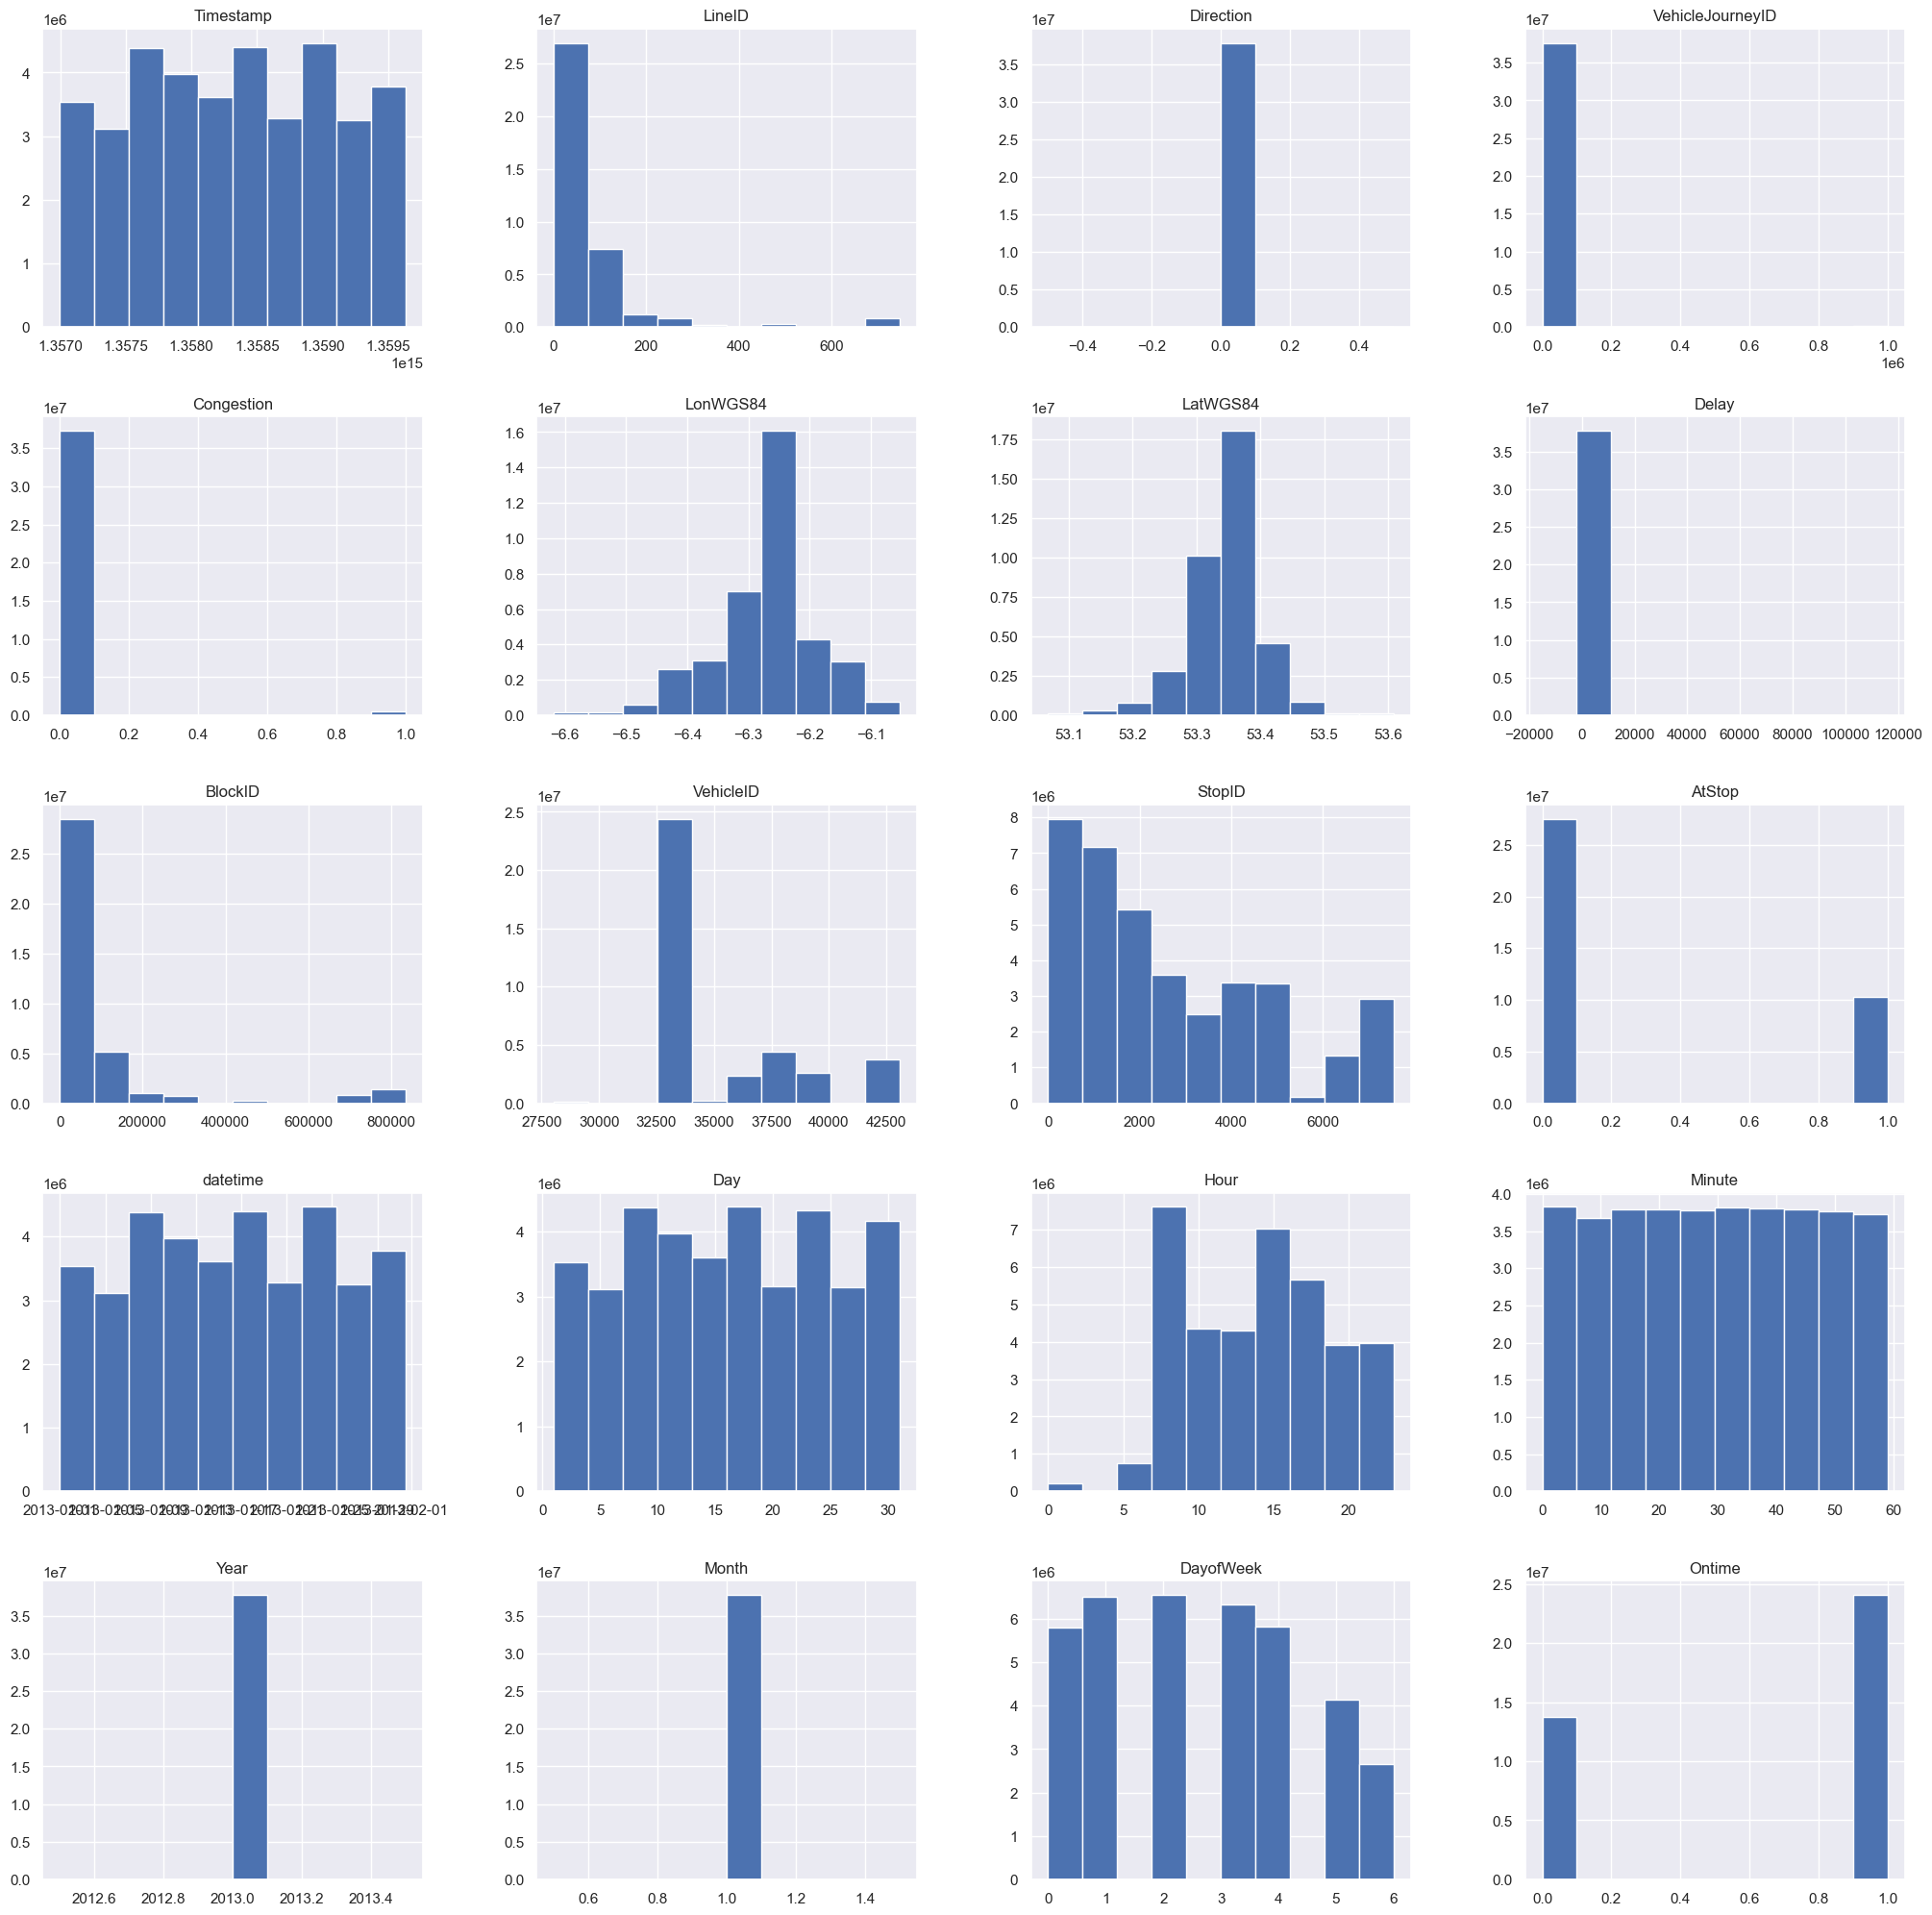

In [18]:
%matplotlib inline
sns.set(color_codes=True)
df.hist(figsize=(25,25));

## Display boxplots of some of the numeric data

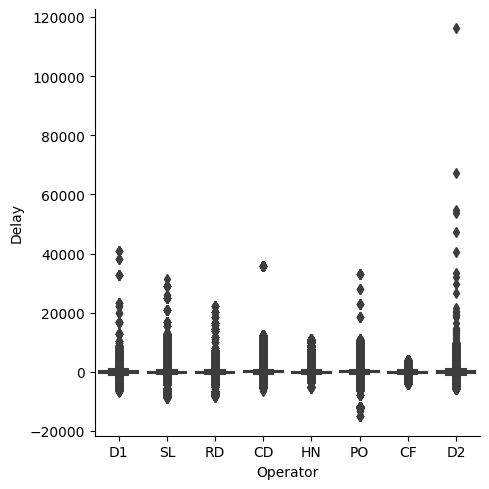

In [17]:

sns.catplot(data=df, x='Operator', y = 'Delay' ,   kind='box', height=8, aspect=1.618)

We can see from the Correlation matrix that none of the variables in the Bus data is correlated to either Delay or Congestion variables

<AxesSubplot: >

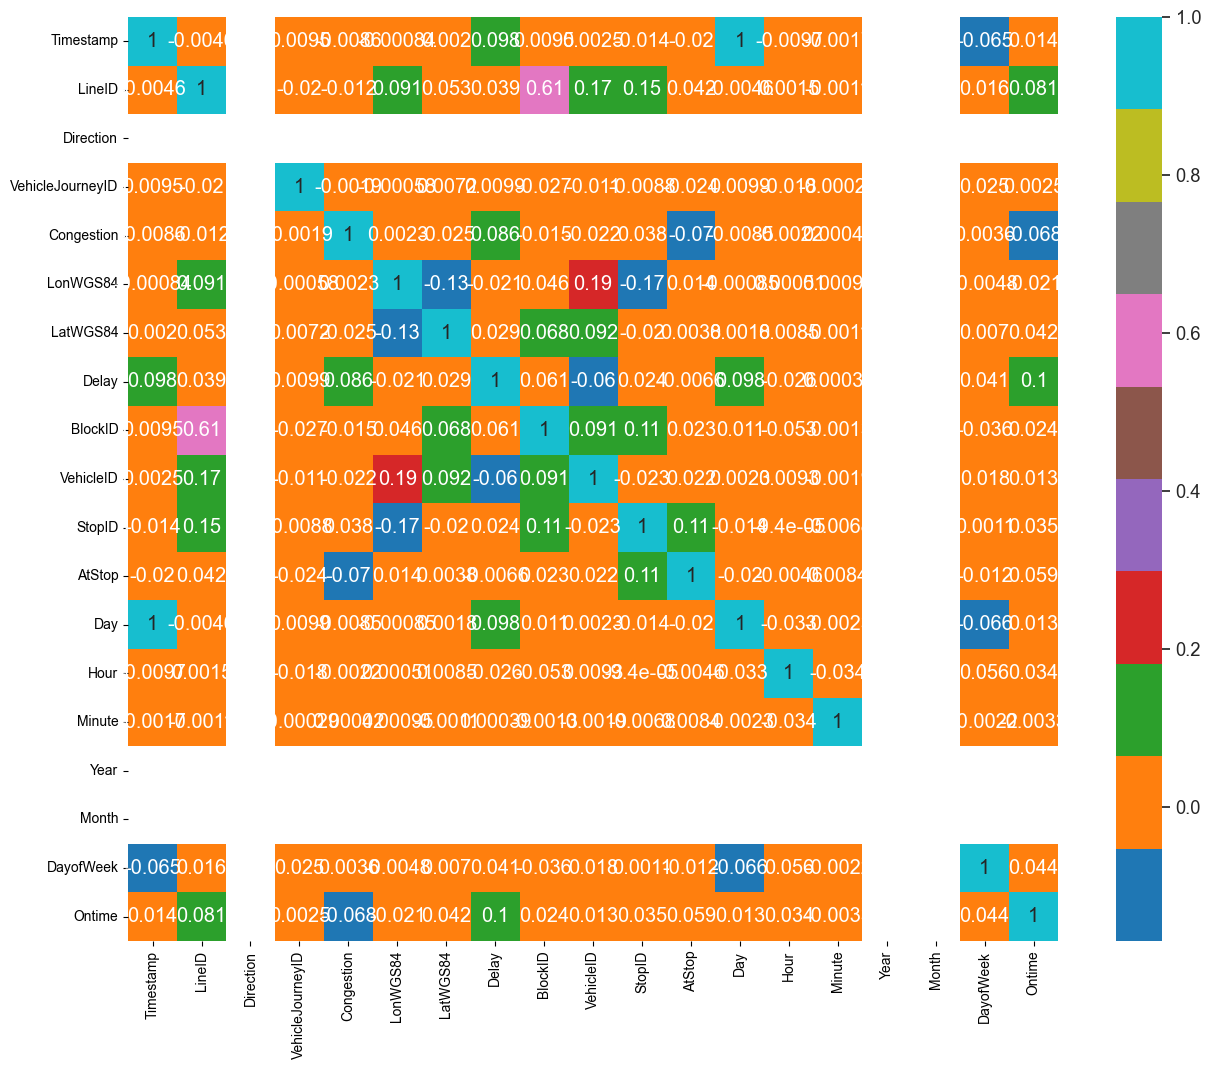

In [ ]:
c_df = df.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="tab10", annot=True)

## Display Numerical Columns


In [20]:
display(NumericalColumns)

['Delay',
 'BlockID',
 'AtStop',
 'StopID',
 'Day',
 'LatWGS84',
 'DayofWeek',
 'LineID',
 'VehicleID',
 'VehicleJourneyID',
 'Timestamp',
 'Hour',
 'LonWGS84',
 'Minute',
 'Ontime']

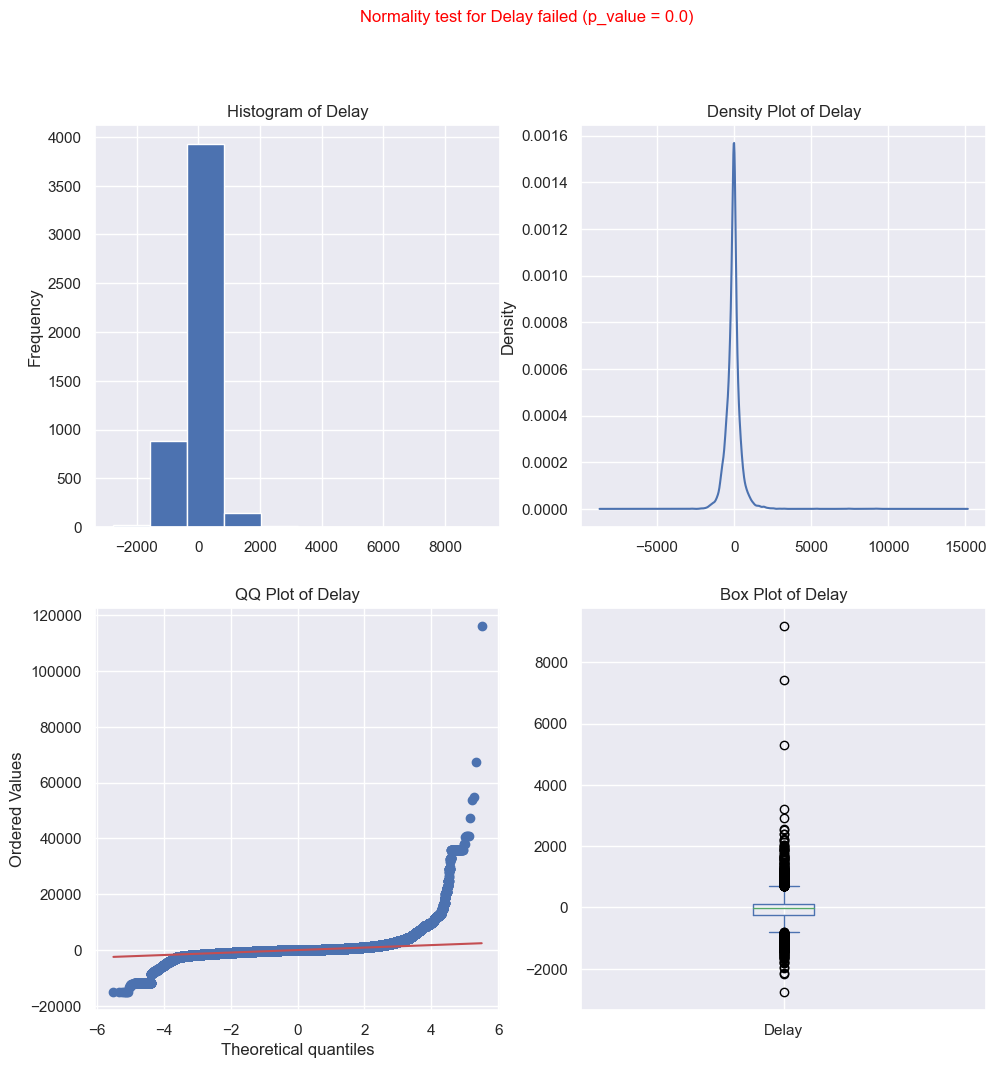

In [21]:
if len(df) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(df)
custom_barplot(df.sample(sampleSize), 'Delay')

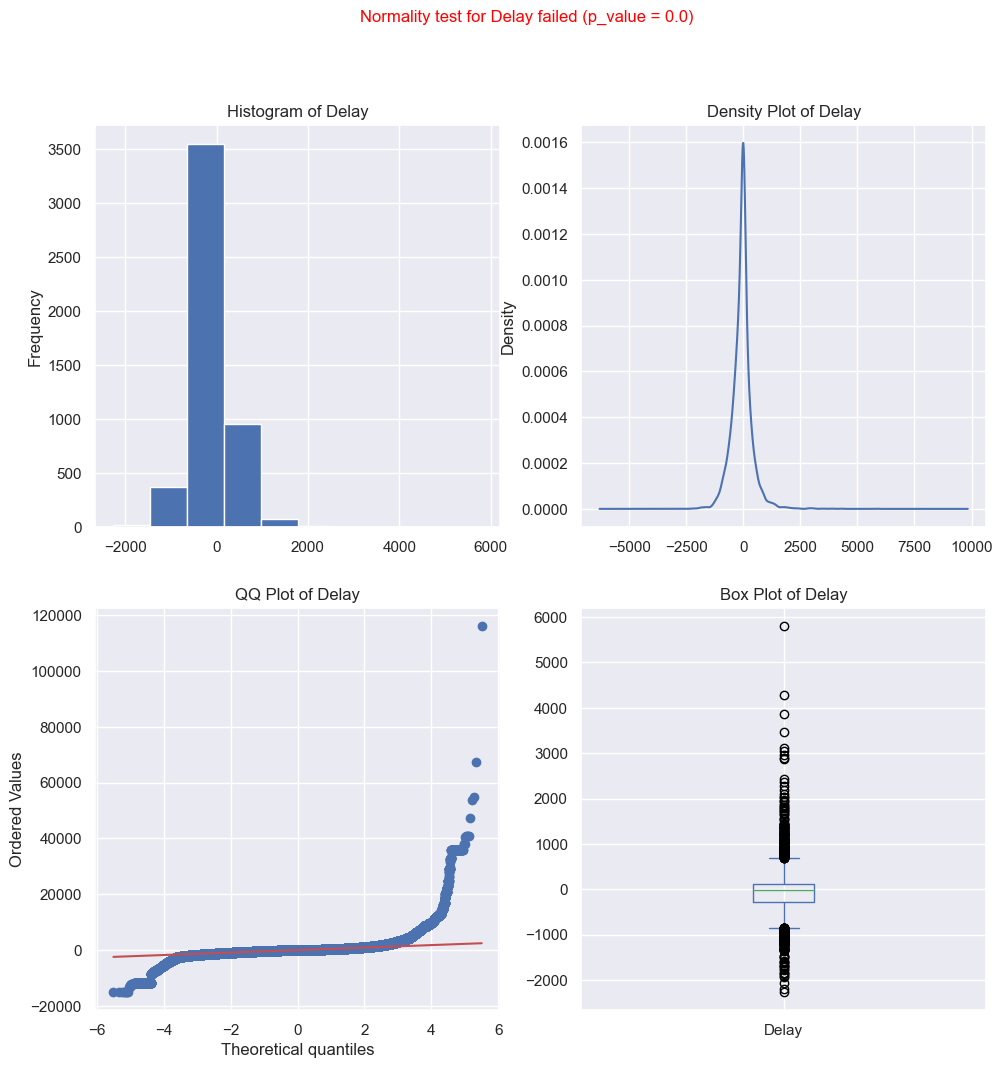

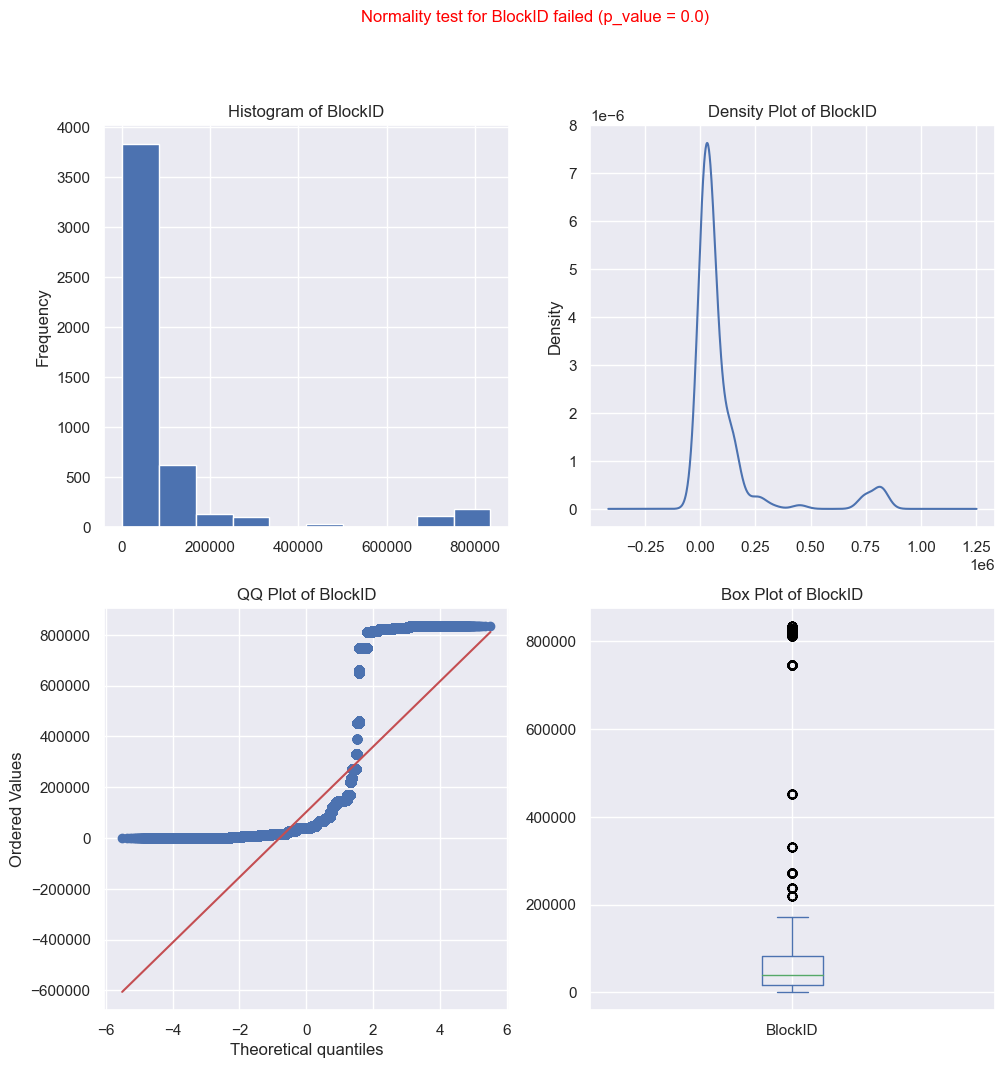

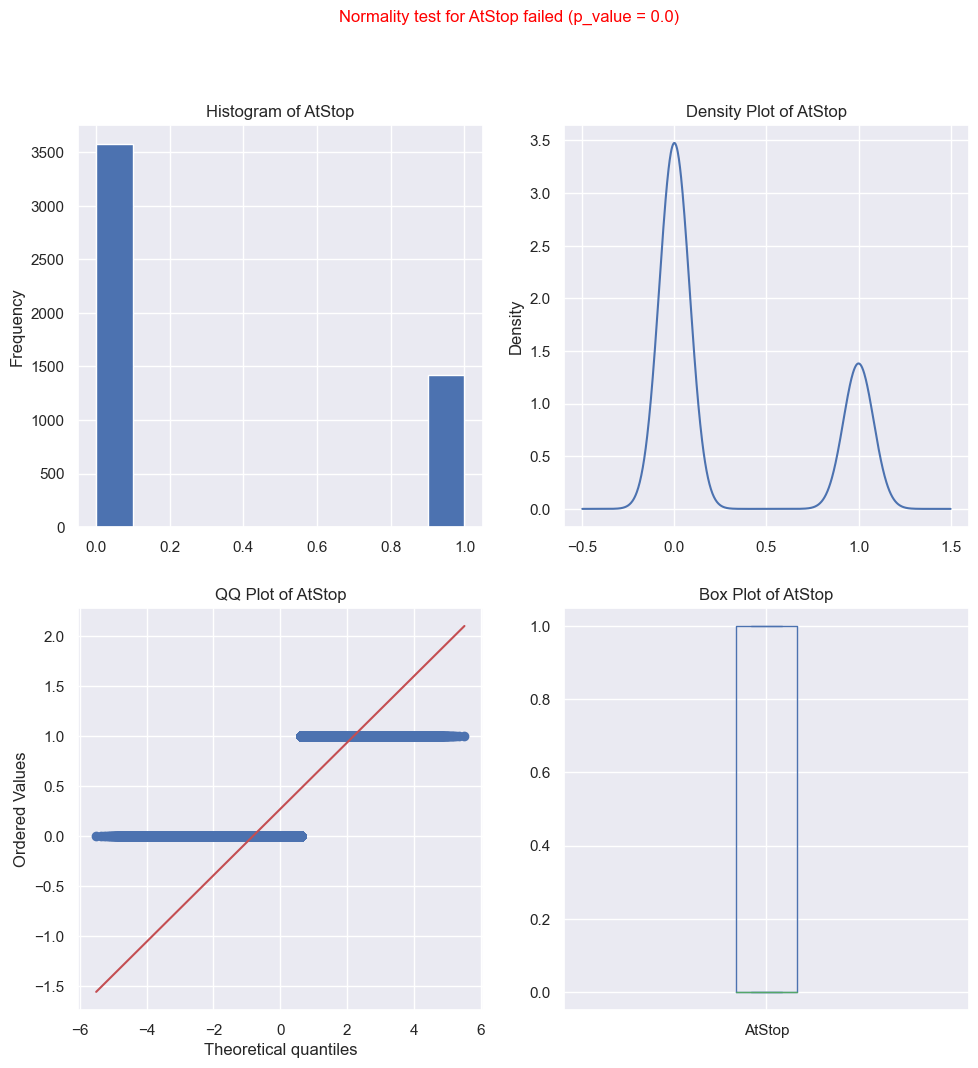

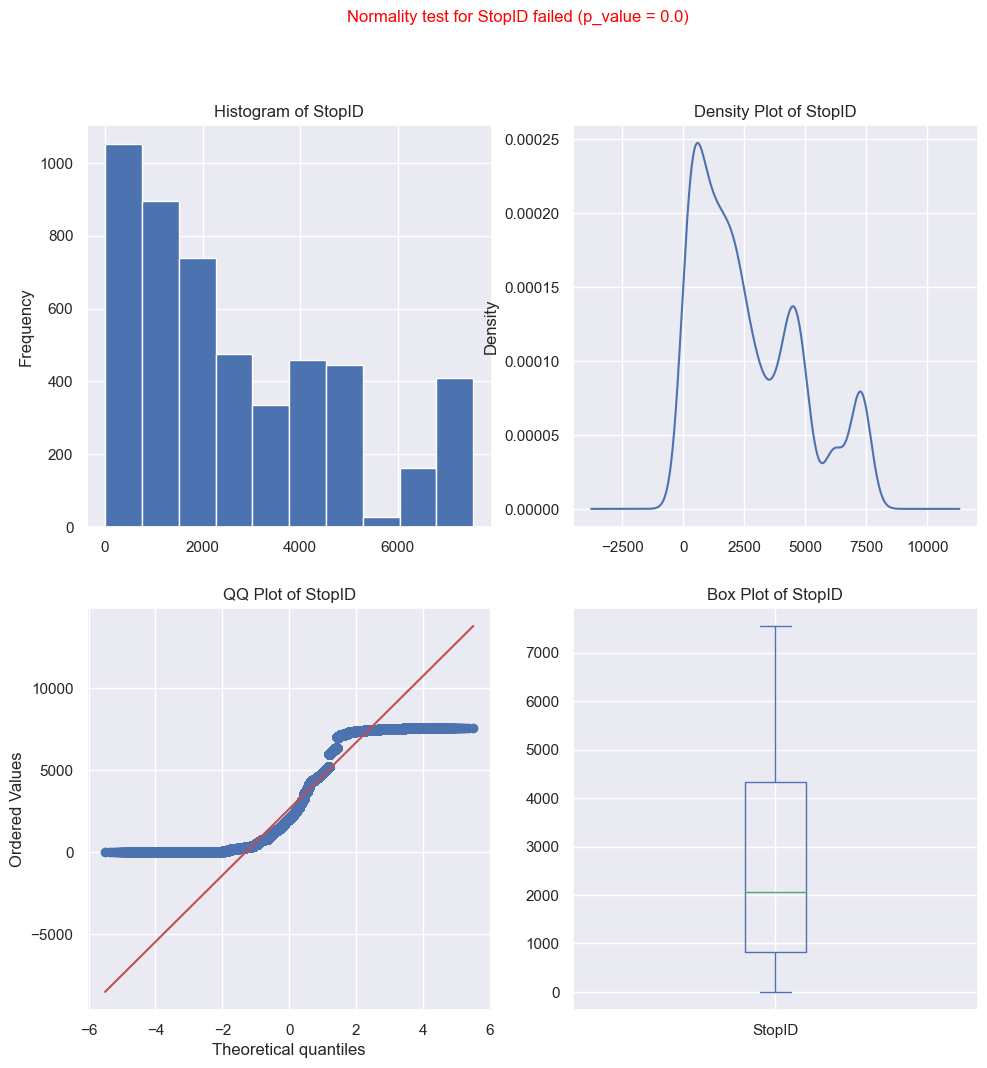

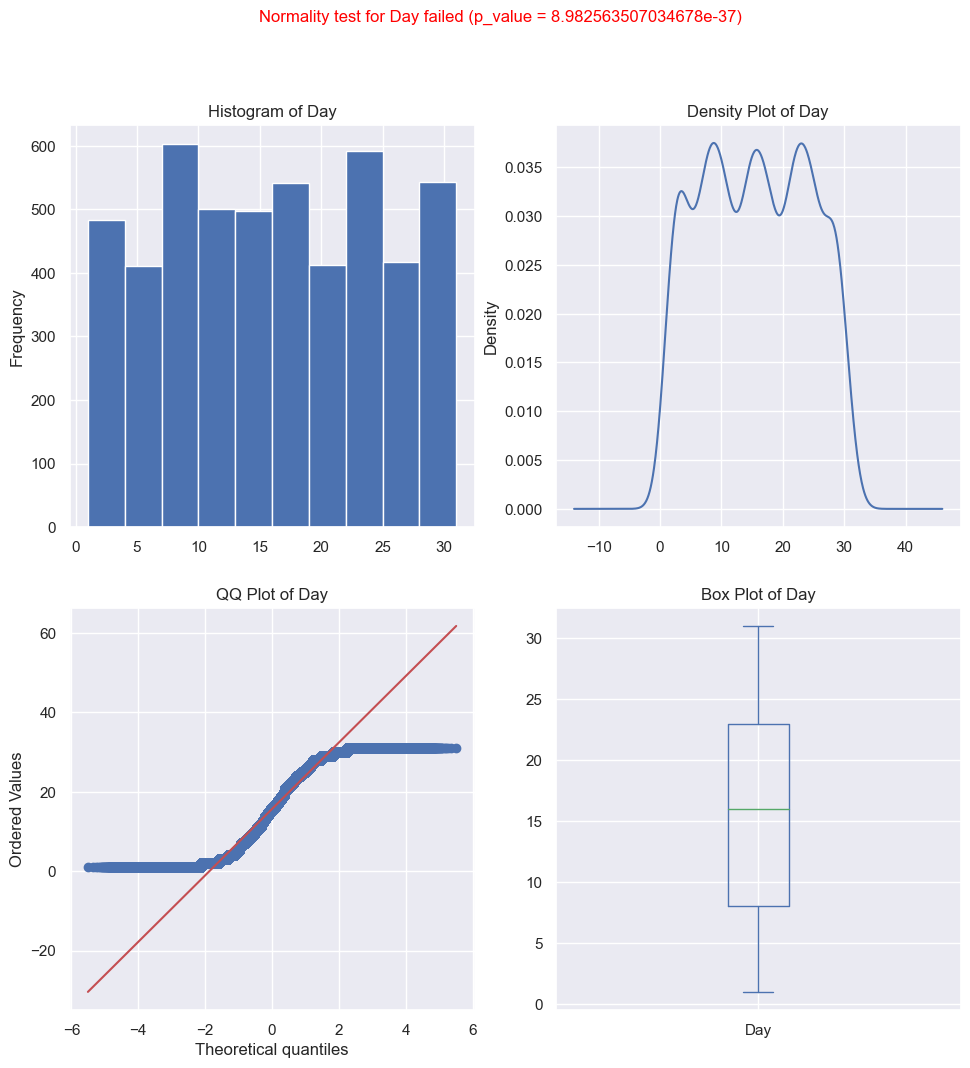

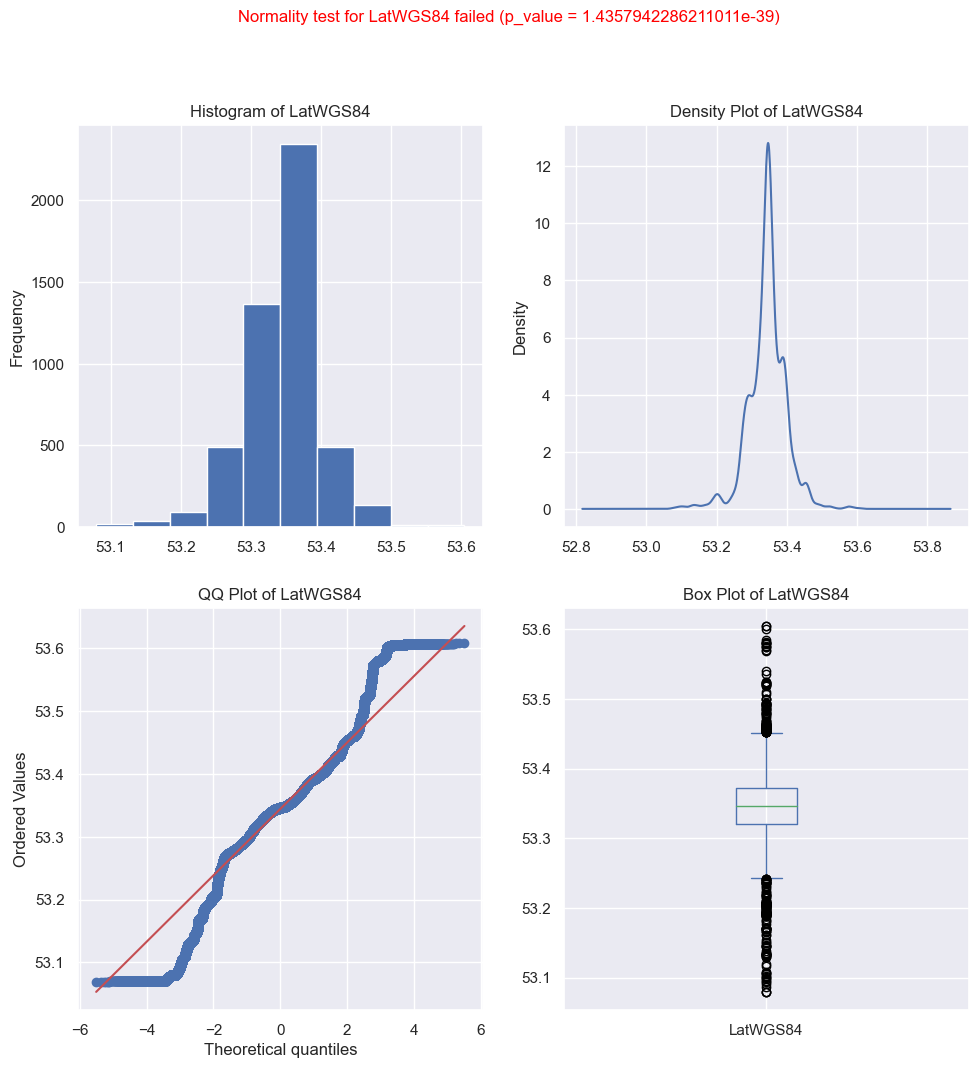

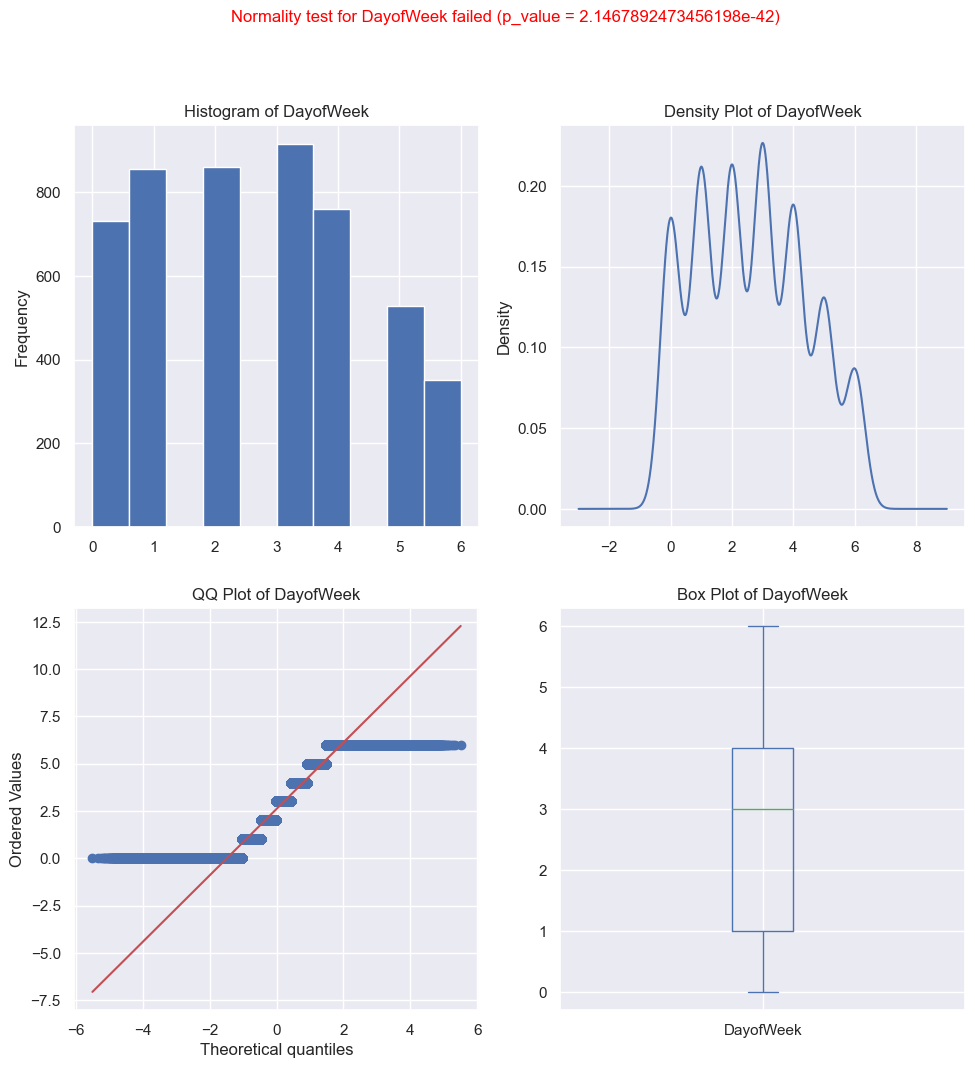

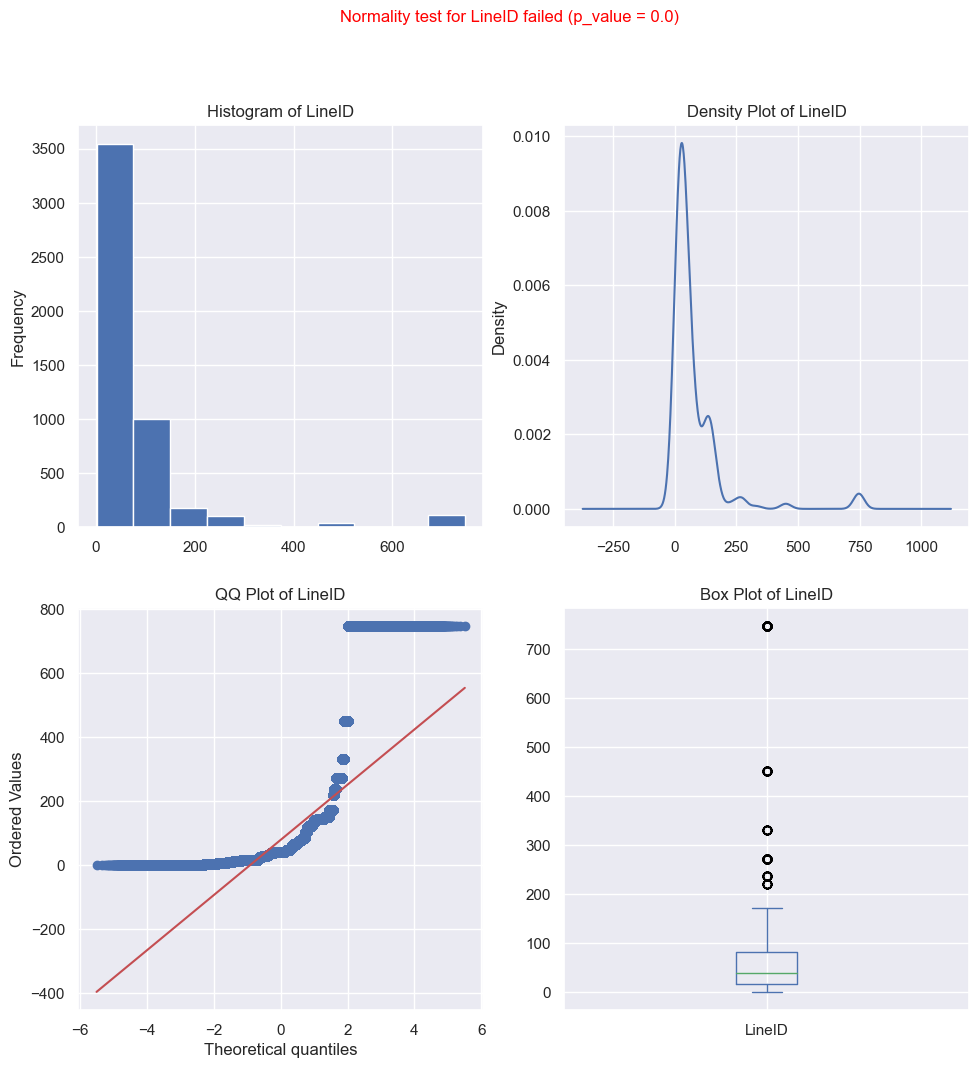

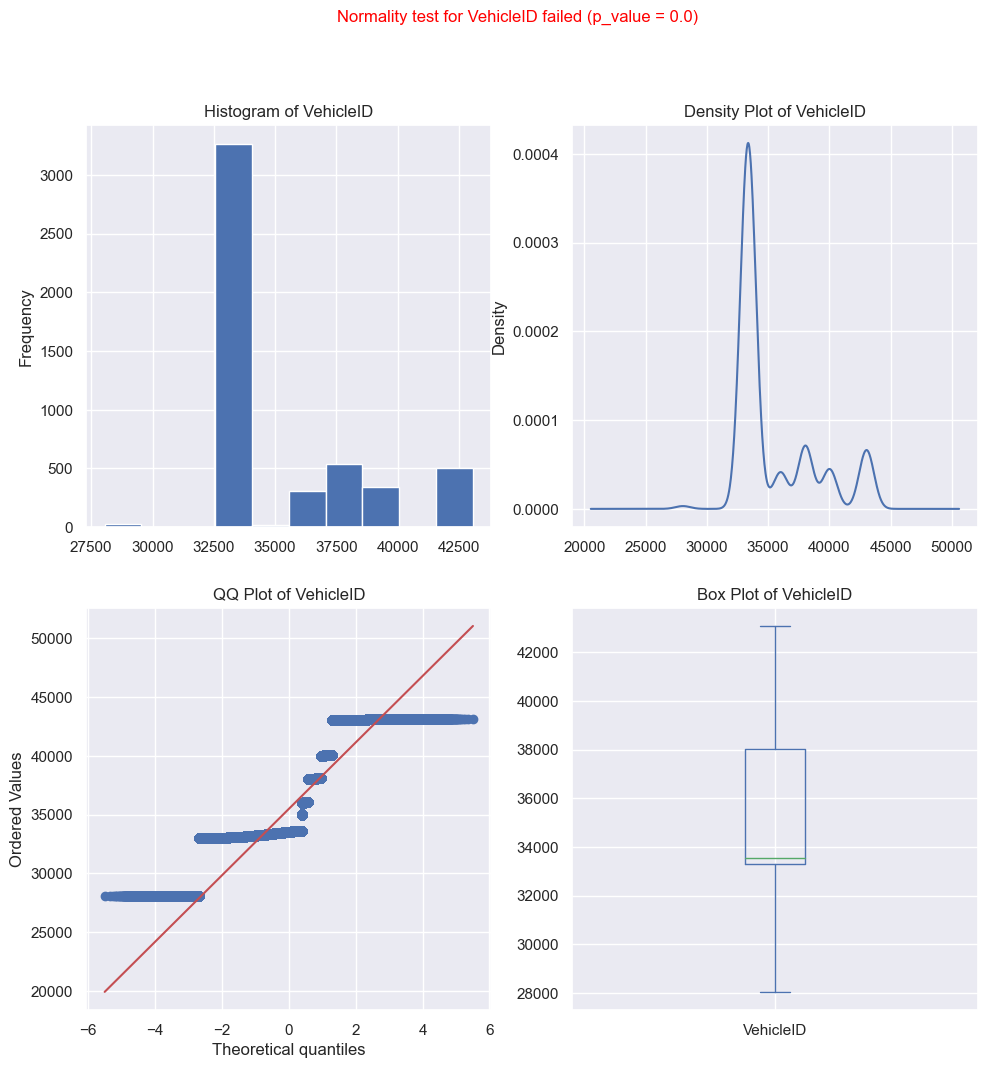

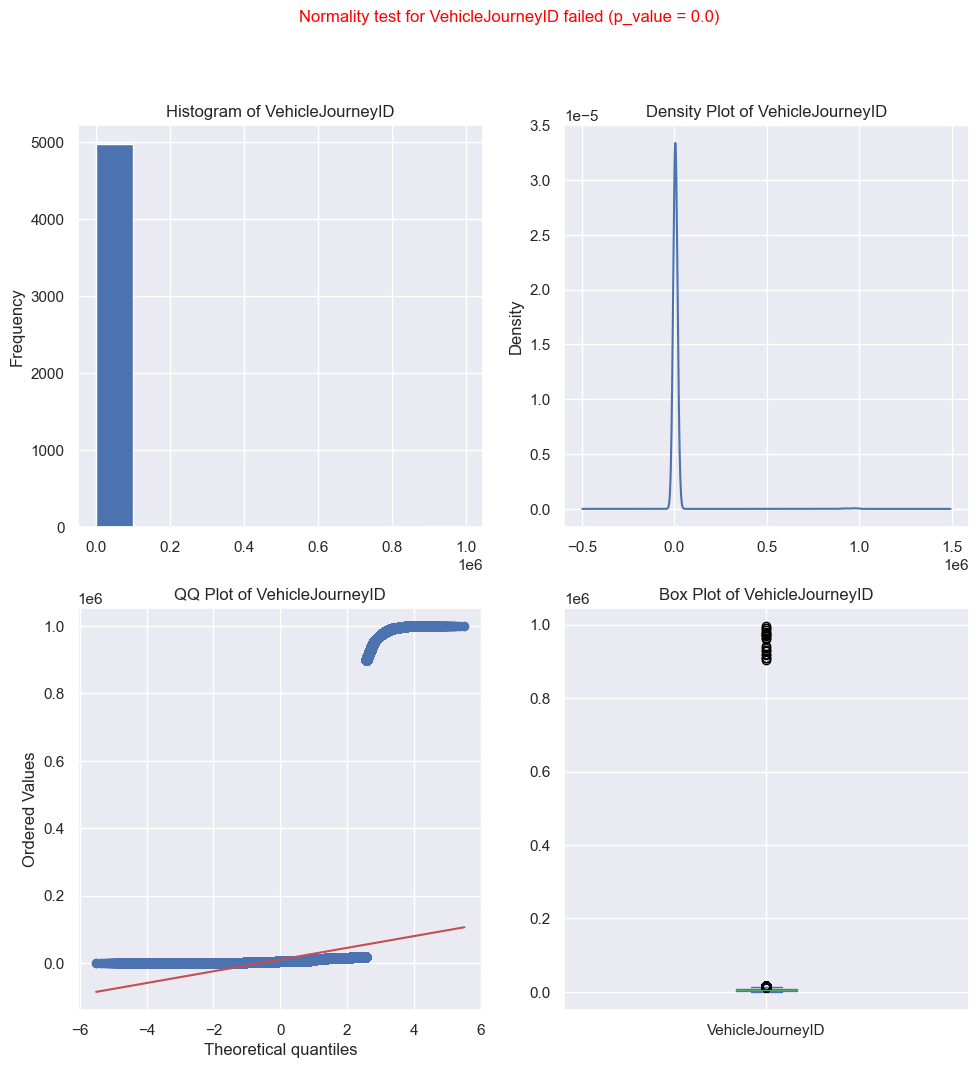

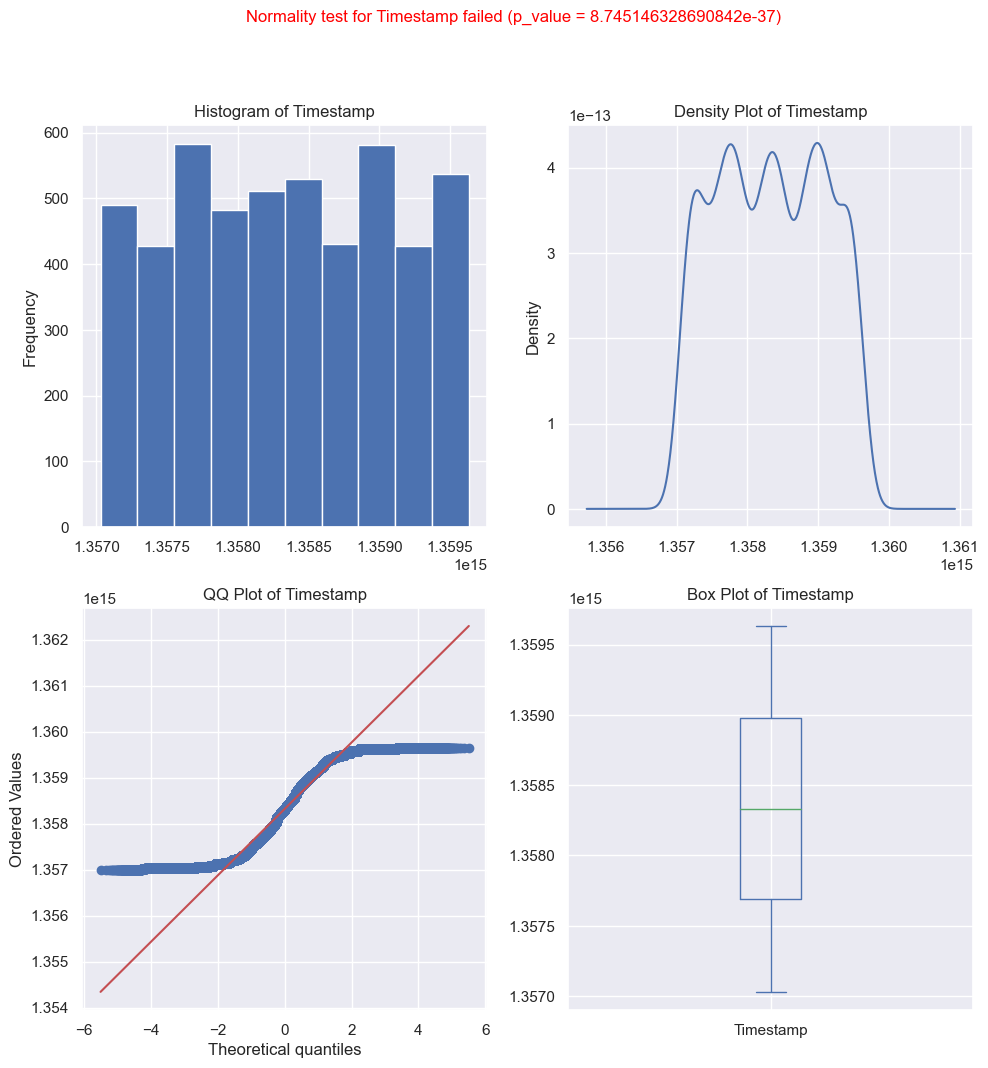

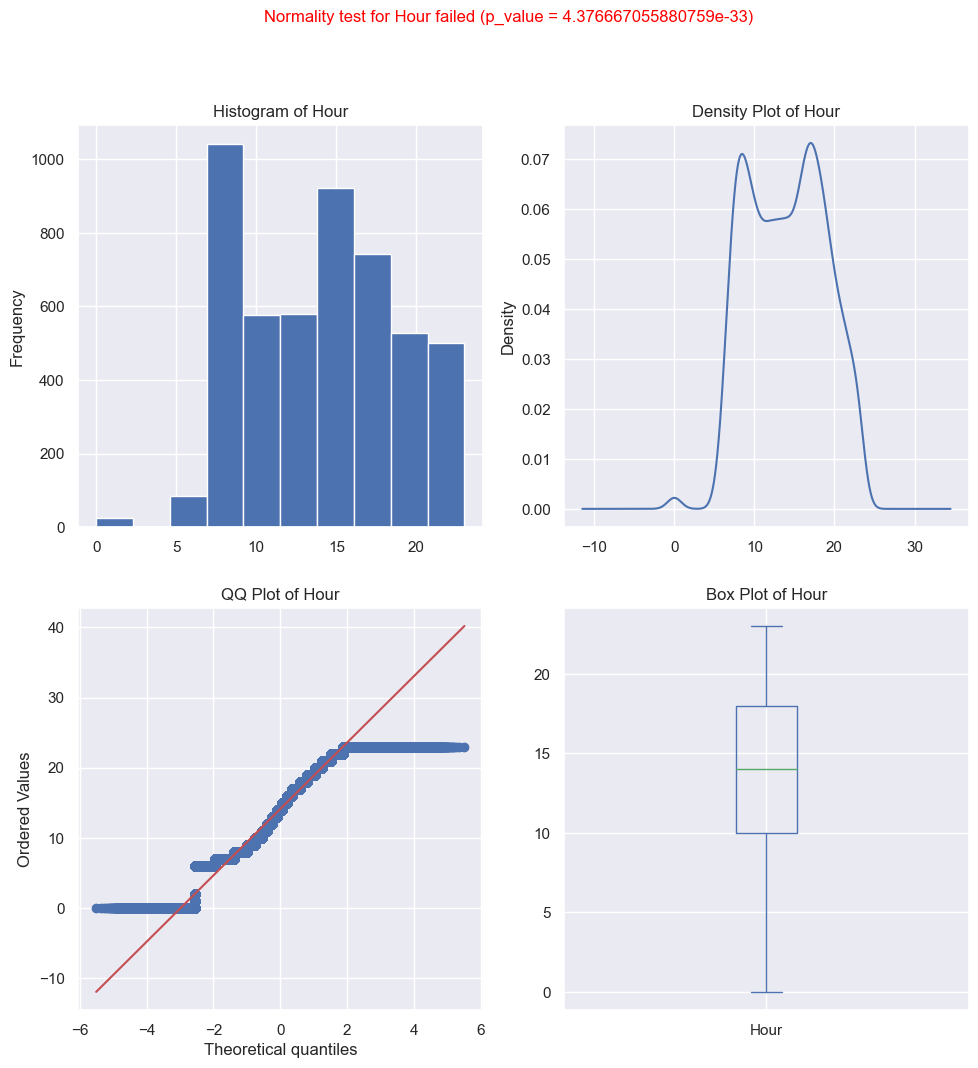

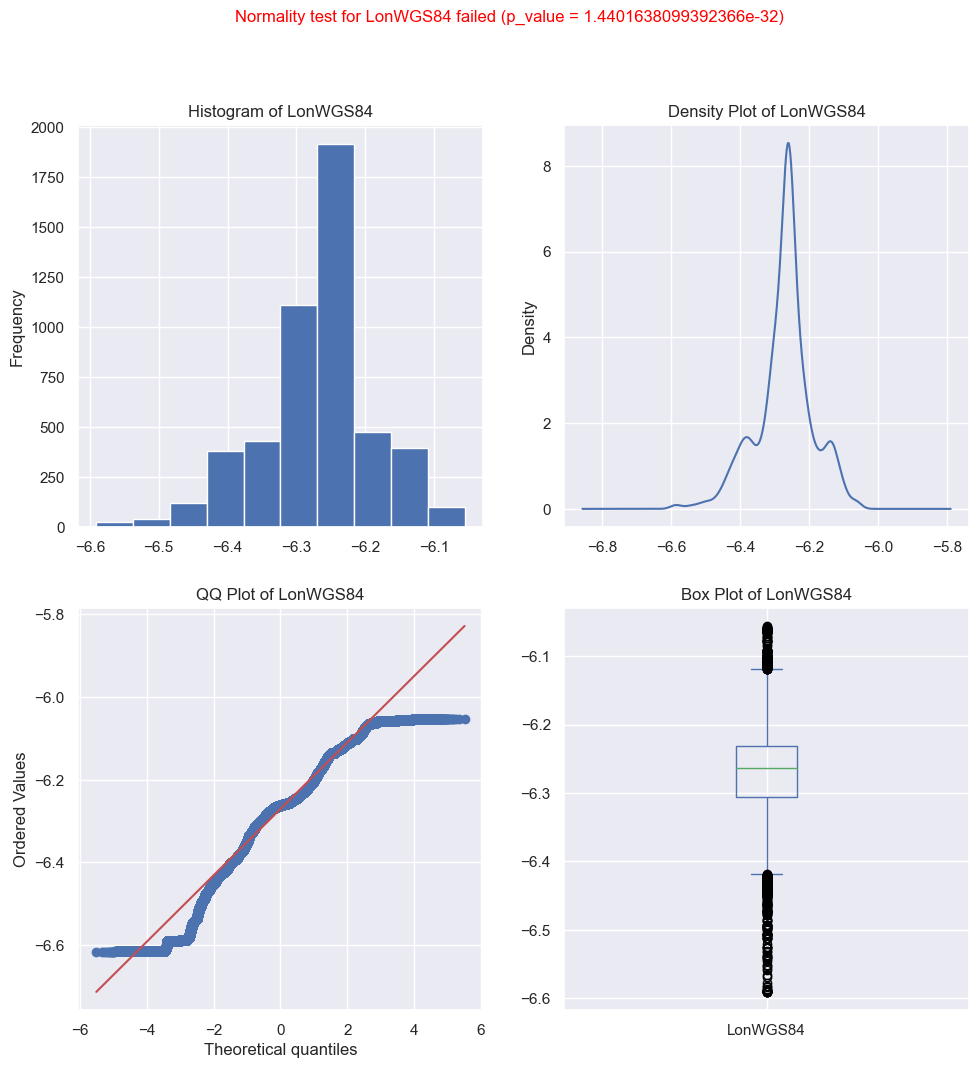

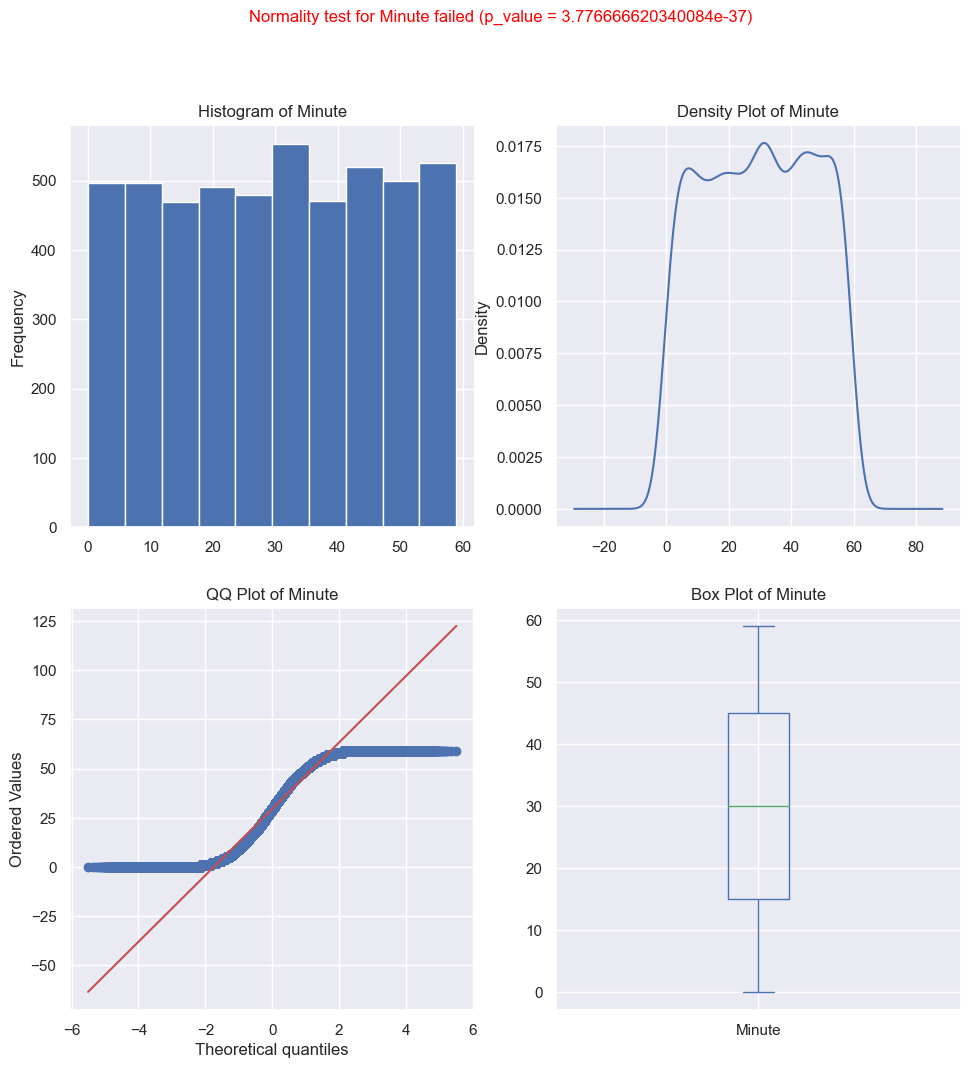

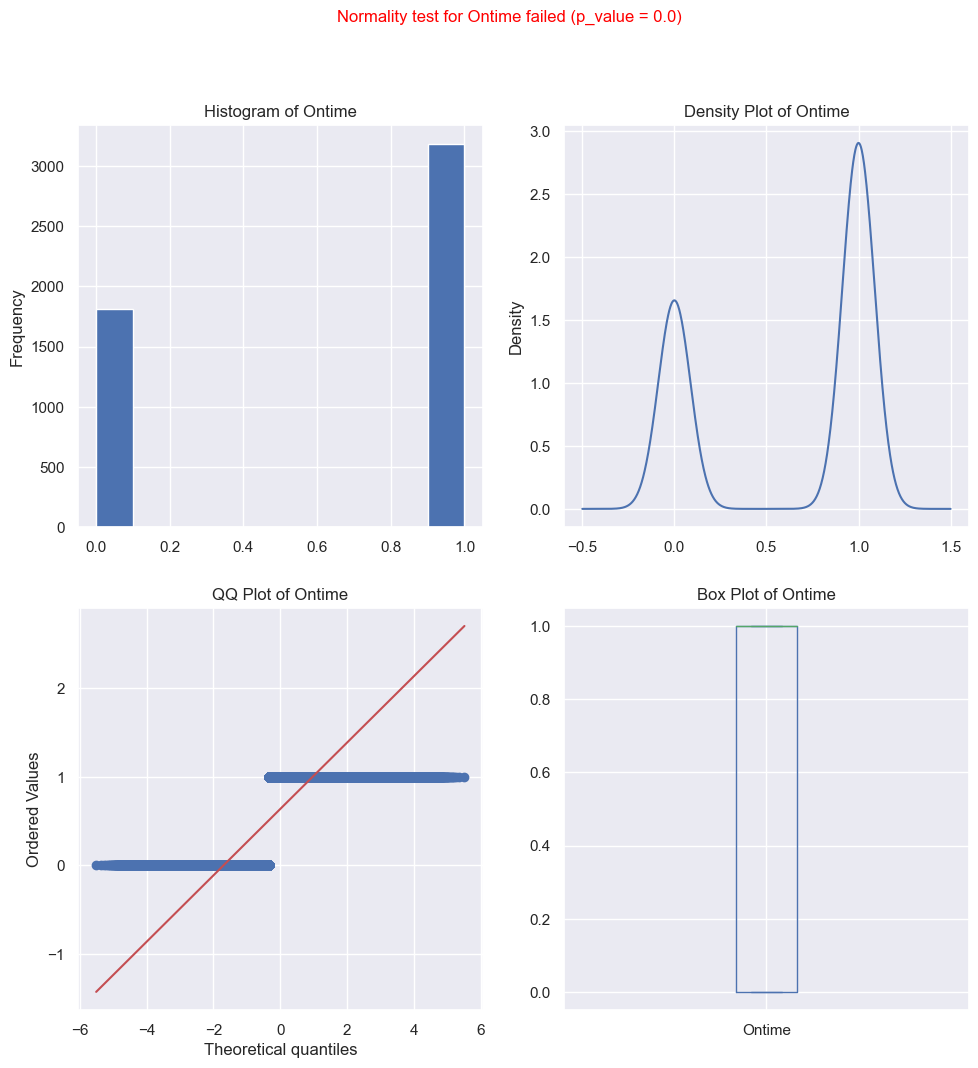

In [22]:
if len(df) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(df)
for f in NumericalColumns:
    custom_barplot( df1=df.sample(sampleSize), col1=f)

In the image below we can see that there seems to be more delayed buses in the center of Dublin than there are in the suburbs

In [23]:
df['Colour'] = df['Delay'].apply(lambda x: 'Black' if (x < -300)  else 'Blue' if  (x > 300)  else 'Yellow')

In [24]:
df['Ontime'] = df['Delay'].apply(lambda x: 0 if (x < -300) or (x > 300) else 1)


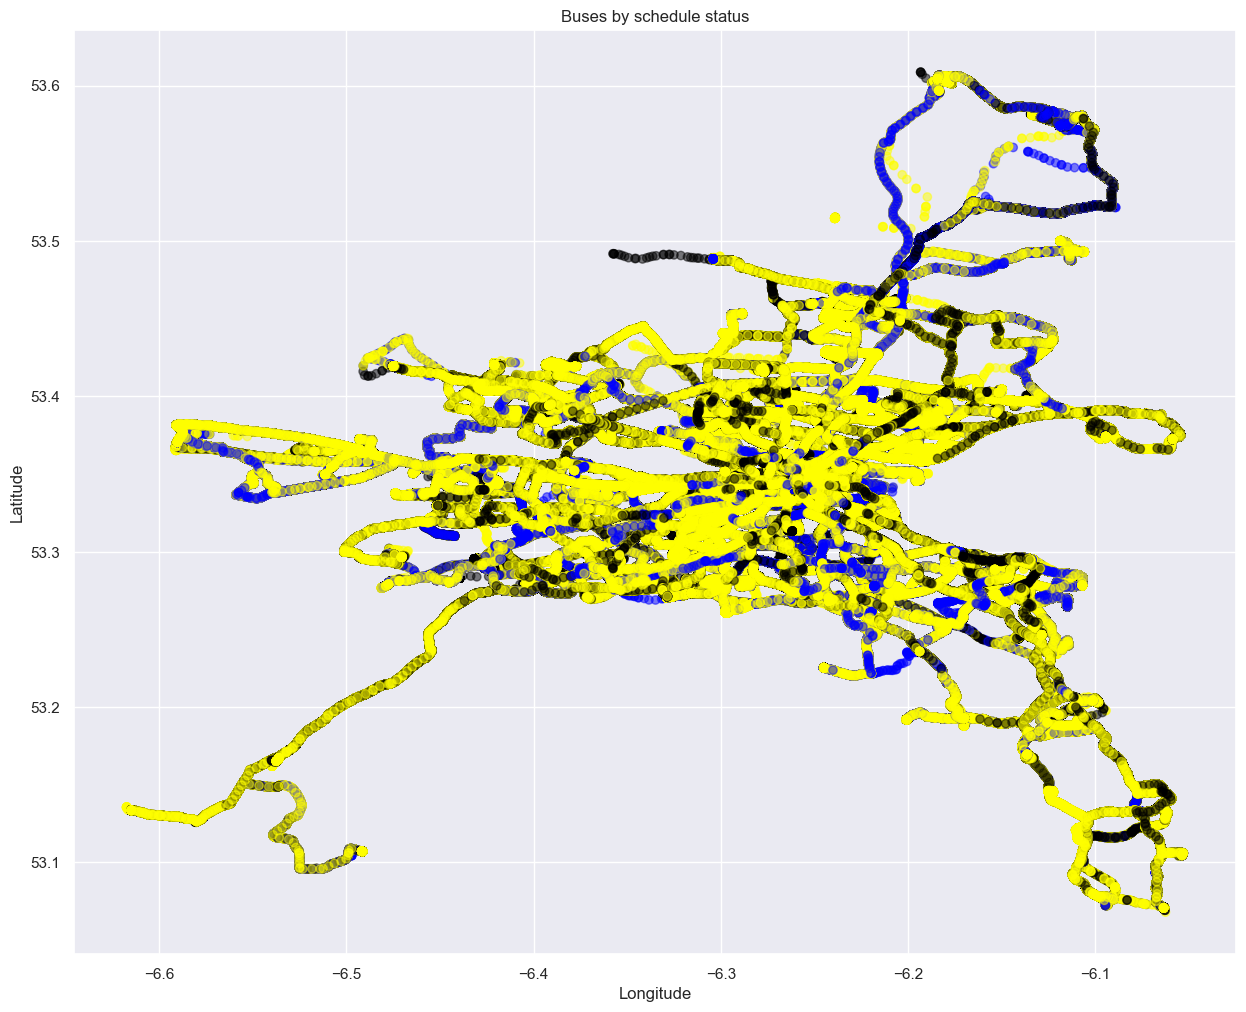

In [25]:
fig, ax = plt.subplots(figsize=(15,12))
plt.scatter(x=df['LonWGS84'], y=df['LatWGS84'], alpha=0.25,  c=df['Colour'] )
plt.title('Buses by schedule status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


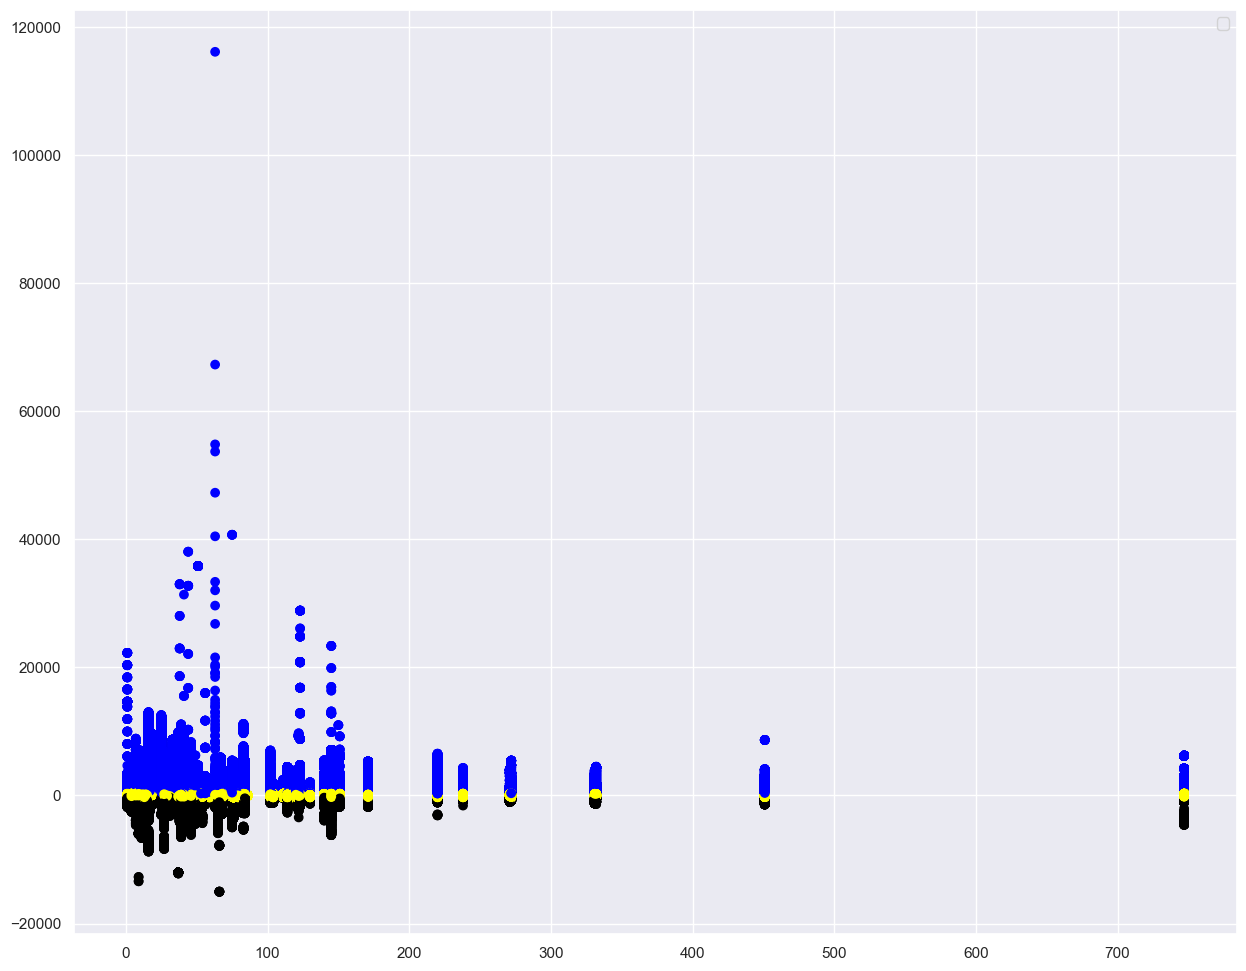

In [26]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['LineID'],df['Delay'], c=df['Colour'])
ax.legend()
plt.show()

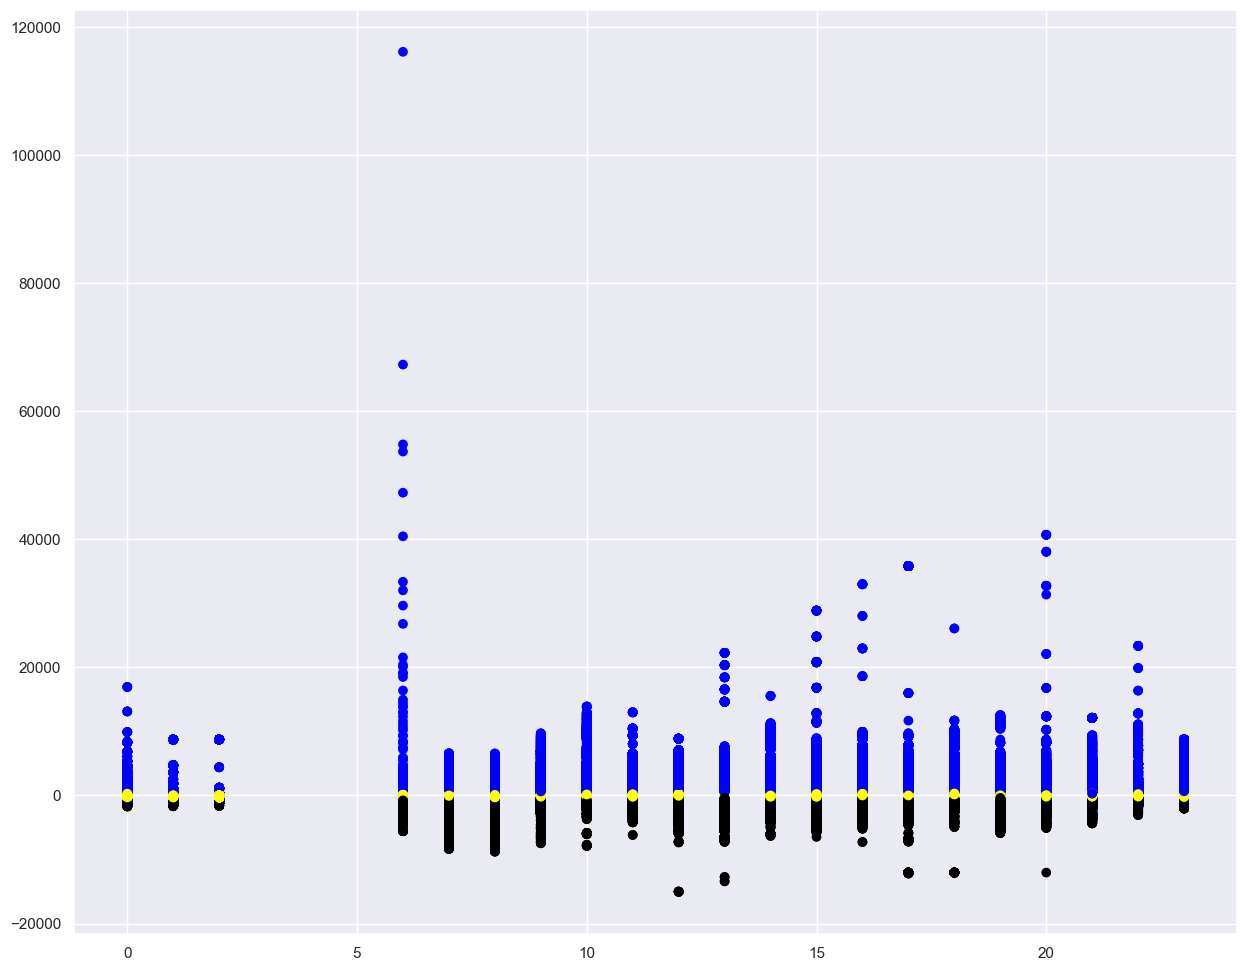

In [27]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Hour'],df['Delay'], c=df['Colour'])
plt.show()


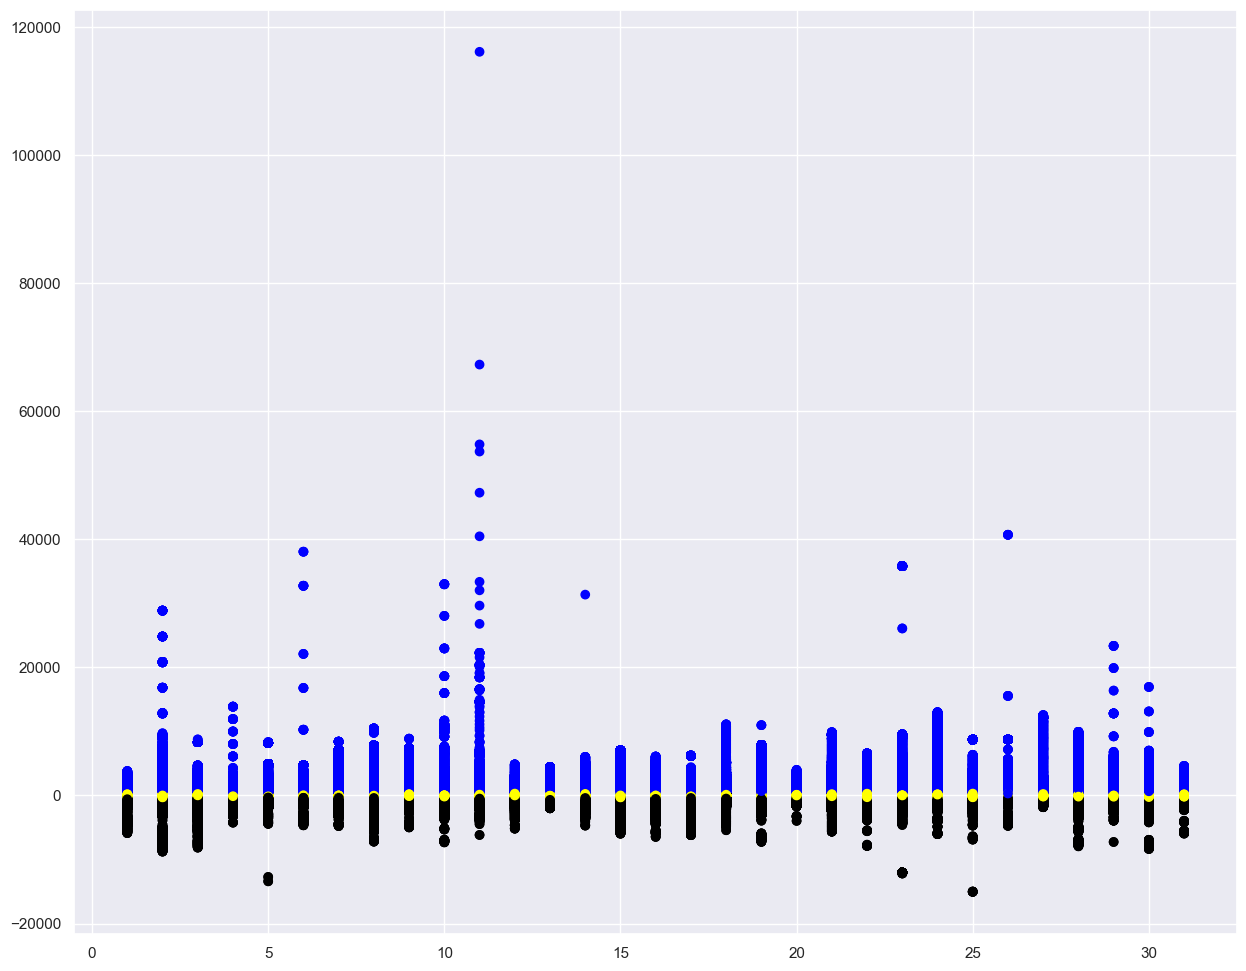

In [28]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['Day'],df['Delay'], c=df['Colour'])
plt.show()

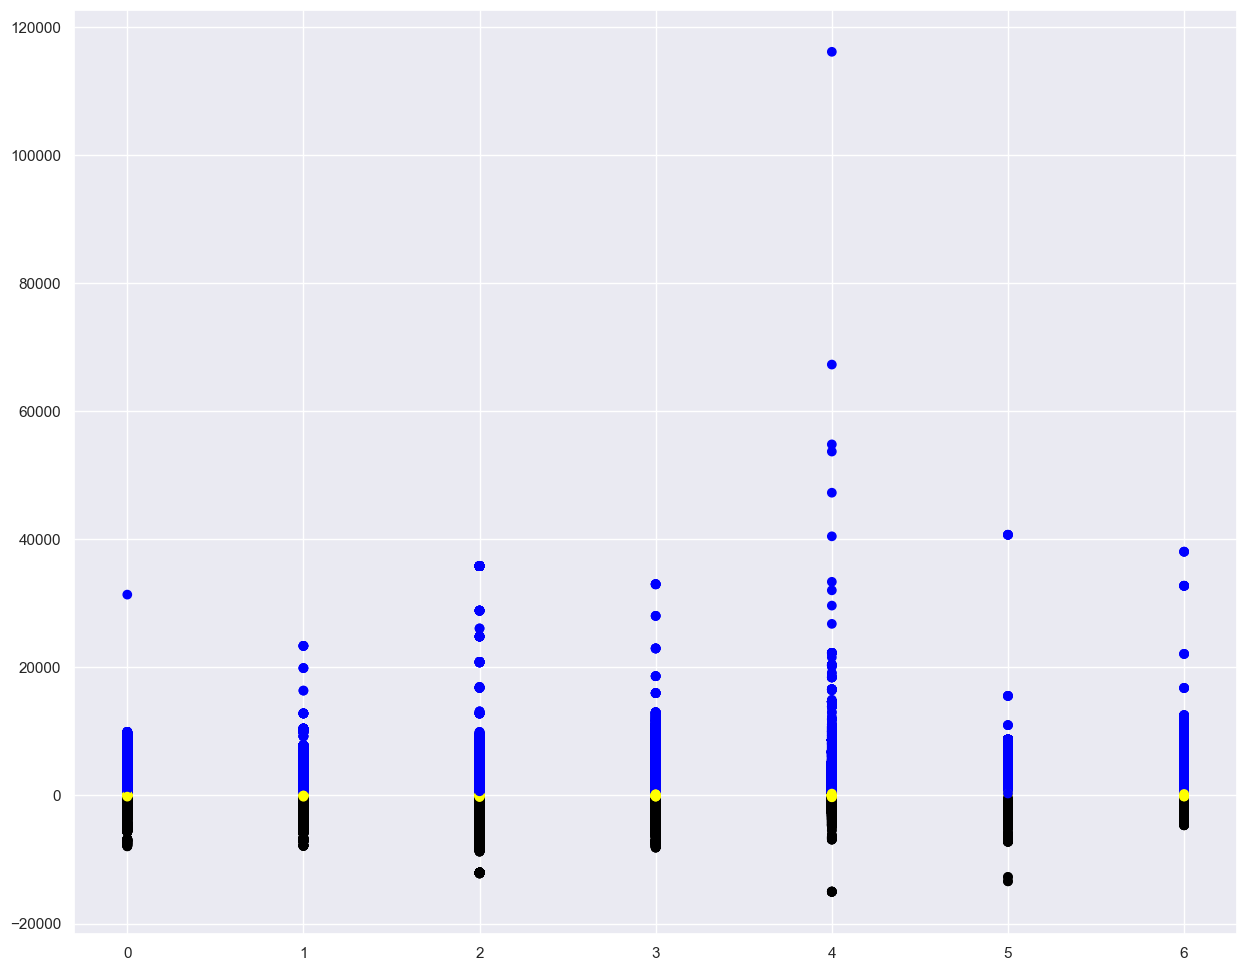

In [29]:
fig, ax = plt.subplots(figsize=(15,12))
ax.scatter(df['DayofWeek'],df['Delay'], c=df['Colour'])
plt.show()

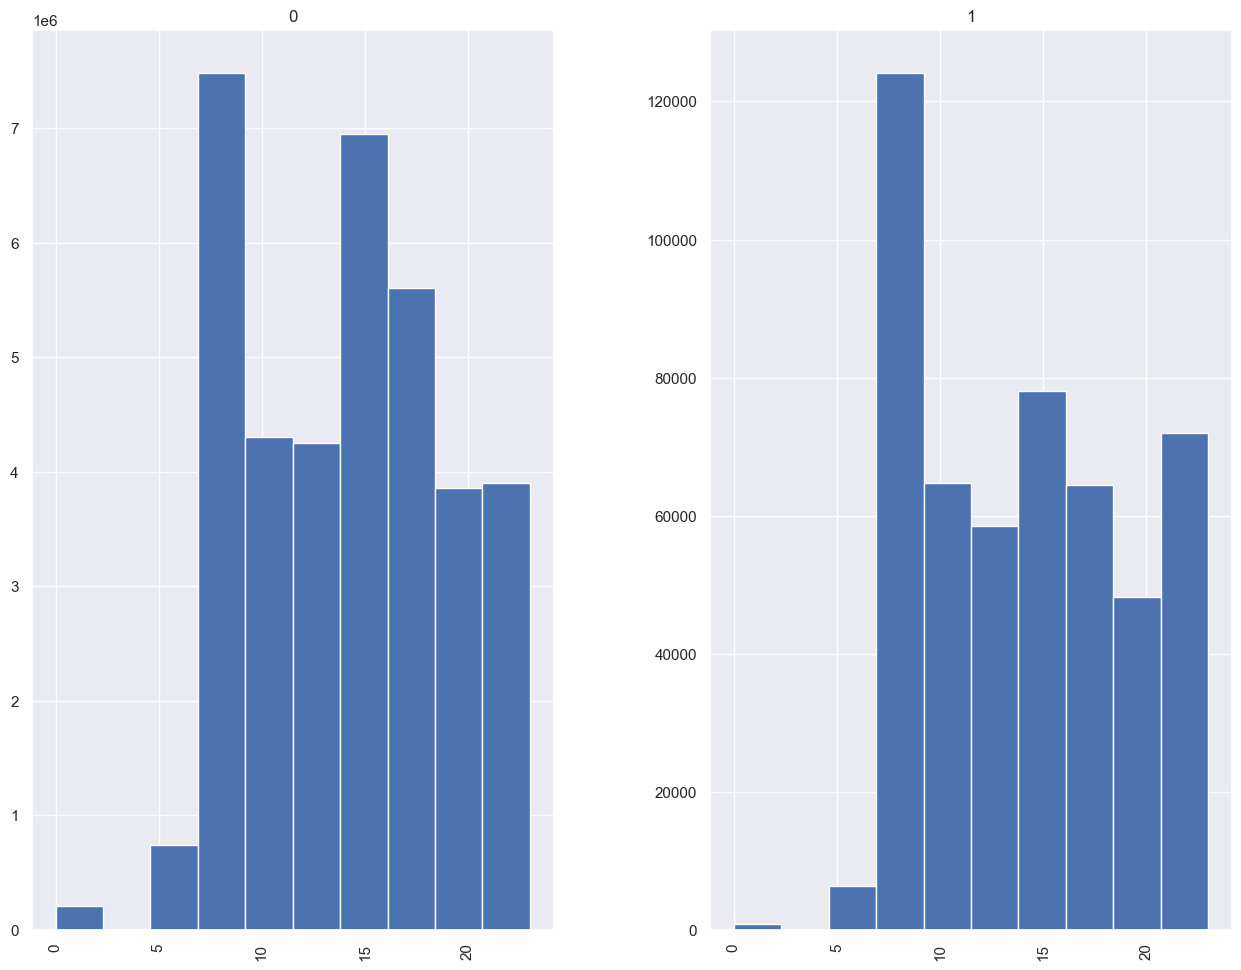

In [30]:

df.hist(by = 'Congestion', column= 'Hour', figsize=(15,12));


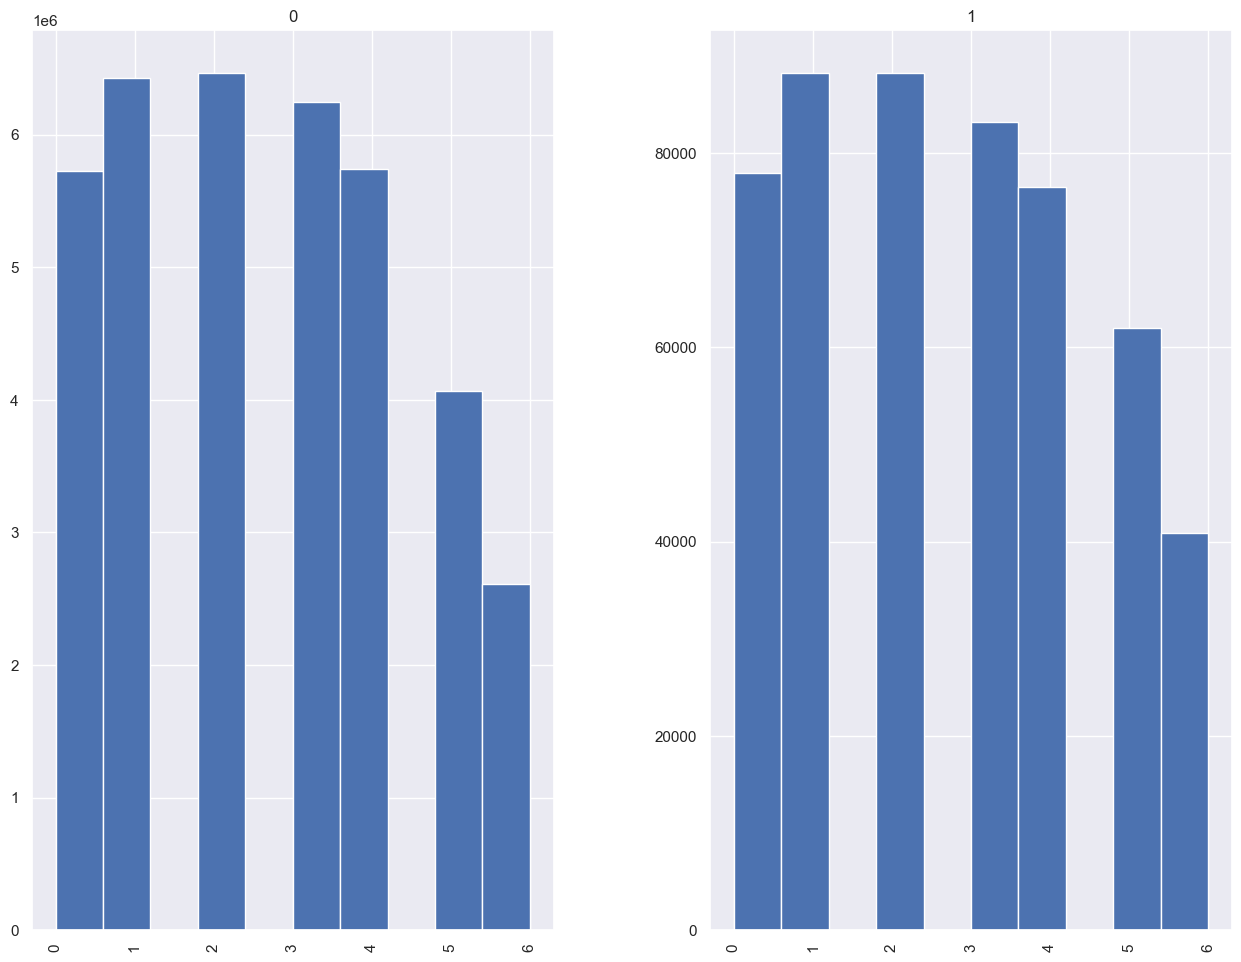

In [31]:

df.hist(by = 'Congestion', column= 'DayofWeek',figsize=(15,12));


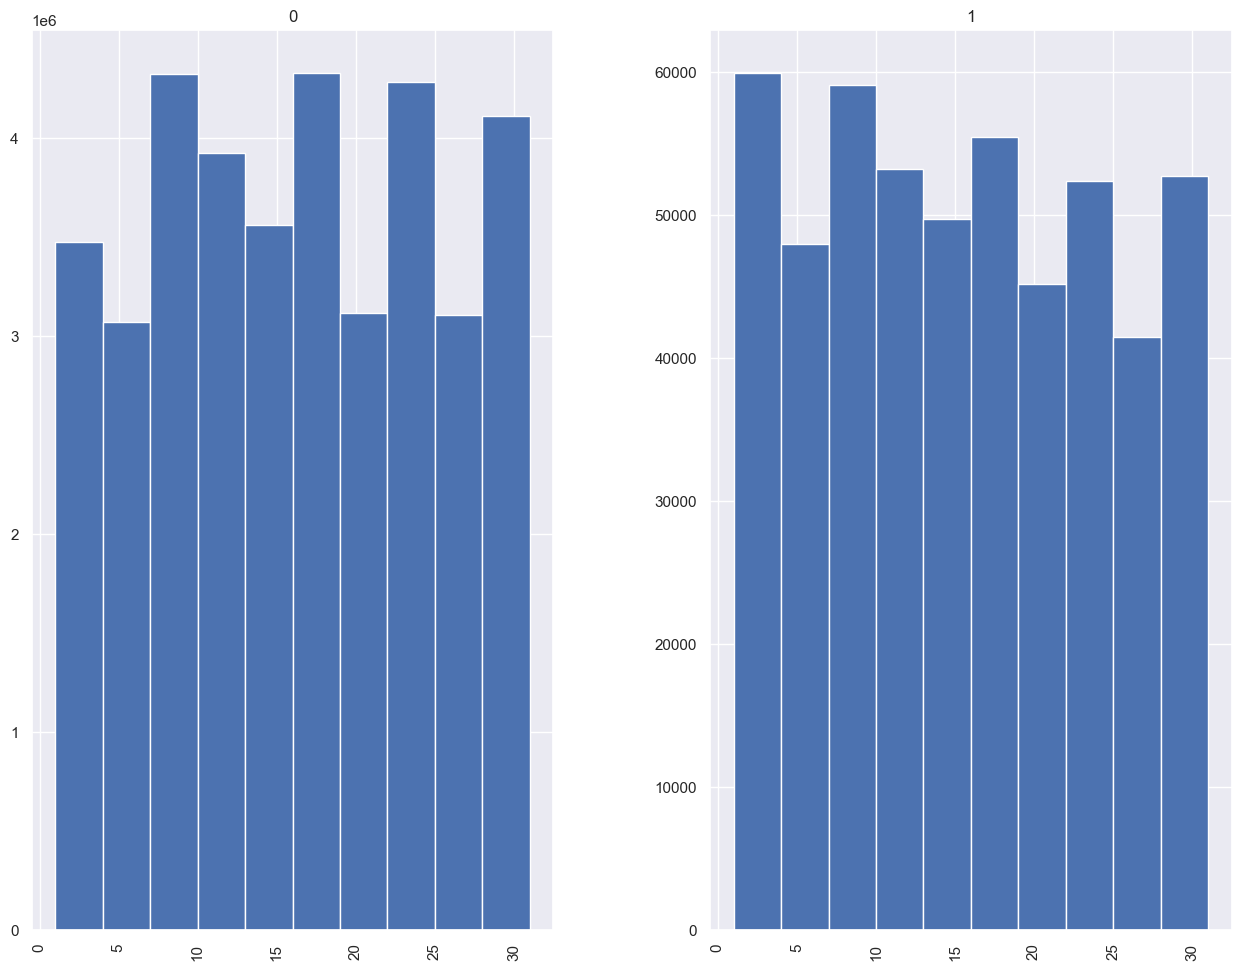

In [32]:
df.hist(by = 'Congestion', column= 'Day',figsize=(15,12));

array([<AxesSubplot: title={'center': '0'}>,
       <AxesSubplot: title={'center': '1'}>], dtype=object)

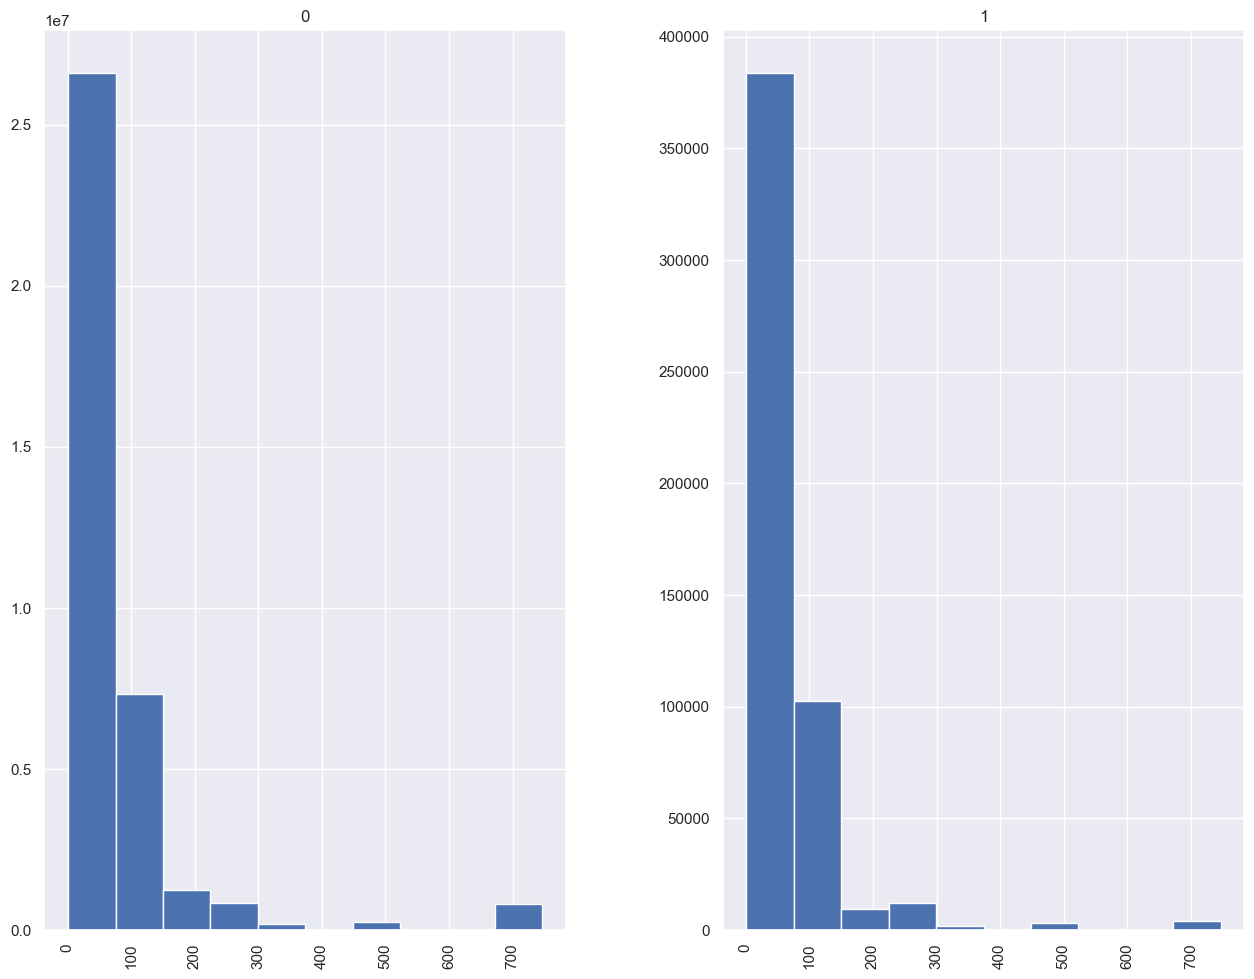

In [33]:
df.hist(by = 'Congestion', column= 'LineID',figsize=(15,12))

### Individual Bus Routes displayed

In [34]:


busRoutes = sorted(busRoutes)
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'Bus Route',
    )

i = interactive(custom_scatterplot, df1 =fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)


# Download the weather station details https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv
## Download the weather stations csv file

In [35]:
df.to_parquet('./Data/CleanedBusData.parquet')
df.shape

(37804234, 25)

In [36]:
url = 'https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv'


### Load the weather statio details for Dublin
Get the information for the Dublin weather stations -done

In [37]:
weatherStations = pd.read_csv(url)
weatherStations = weatherStations[weatherStations['county'].str.contains('Dublin')]
weatherStations.head(10)

county  station name                              name  height(m)  \
575  Dublin         10323            STILLORGAN (FARMLEIGH)         67   
576  Dublin         10123       DUBLIN (FITZWILLIAM SQUARE)         16   
577  Dublin         10223  ROYAL BOTANIC GARDENS (GLASNEVIN         17   
578  Dublin          1223                    BELGARD CASTLE        125   
579  Dublin           632                         LUSK G.S.         23   
580  Dublin          1232           KINSALEY (AGR.RES.STN.)         19   
581  Dublin          2523                 DUBLIN (Ringsend)          7   
582  Dublin          2623                      HOWTH CASTLE         11   
583  Dublin          2723          STILLORGAN (VARTRY HSE.)         80   
584  Dublin          2732                         ARDGILLAN         62   

     easting  northing  latitude  longitude open year close year  
575   320514    227230  53.28194   -6.19389      1915       1935  
576   316404    233098  53.33556   -6.25333      1908       1937  
577   315083    237179  53.37250   -6.27167      1880       1925  
578   307400    229300  53.30278   -6.38889      1914       1963  
579   321700    254300  53.52500   -6.16528      1949       2012  
580   321500    242900  53.42222   -6.17222      1961       2004  
581   318900    233900  53.34167   -6.21389      1911     (null)  
582   327900    239000  53.38611   -6.07778      1913       1971  
583   320200    226800  53.27778   -6.19722      1915       1999  
584   321791    261102  53.58583   -6.16167      1894       1938

In [38]:
dublinStations = weatherStations[["station name", "name"]]



In [39]:
dublinStations.columns = [x.strip().replace(' ', '') for x in dublinStations.columns]


### Loop through this data and download the hourly weather data into Data/Weather folder - done

In [40]:
for rows in dublinStations.itertuples():
    # get hourly weather data
    url = "http://cli.fusio.net/cli/climate_data/webdata/hly" + str(rows.stationname) + ".zip"
    print(url)
    dest = './Zips/MetEirrean/hly' + str(rows.stationname) + ".zip"
    try:
        weatherFile = rq.urlretrieve(url, dest)
        continue
    except Exception:
        print('No file exists')  
    # # get the daily weather data - ONLY USING THE HOURLY DATA FOR NOW
    # url = "http://cli.fusio.net/cli/climate_data/webdata/dly" + str(rows.stationname) + ".zip"
    # print(url)
    # dest = './Zips/MetEirrean/dly' + str(rows.stationname) + ".zip"
    # try:
    #     weatherFile = rq.urlretrieve(url, dest)
    #     continue
    # except Exception:
    #     print('No file exists')  

http://cli.fusio.net/cli/climate_data/webdata/hly10323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10123.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly10223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1223.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly632.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1232.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2523.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2623.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2723.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2732.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1323.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly2823.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly1332.zip
No file exists
http://cli.fusio.net/cli/climate_data/webdata/hly

In [41]:
import zipfile as zip
    # Zip creates its own folders - no need to check for folder existence
files = os.listdir('./Zips/MetEirrean/')
WDfiles = [f for f in files if f.startswith('hly')]
for f in WDfiles:
    fp = './Zips/MetEirrean/' + f
    with zip.ZipFile(fp,  mode='r') as arc: 
        arc.extractall('./Data/MetEirrean/')



In [42]:
files = os.listdir('./Data/MetEirrean/')  
WDfiles = [f for f in files if f.endswith('.csv')] # need to remove the empty files

### Read the weather data and load in the hourly weather data between the min and max dates - done

In [43]:
Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')

Phoenix_wdf['datetime'] = pd.to_datetime(Phoenix_wdf['date'])
Phoenix_wdf['Year'] = Phoenix_wdf['datetime'].dt.year
Phoenix_wdf['Month'] = Phoenix_wdf['datetime'].dt.month
Phoenix_wdf['Day'] = Phoenix_wdf['datetime'].dt.day
Phoenix_wdf['Time'] = Phoenix_wdf['datetime'].dt.time
Phoenix_wdf['Hour'] = Phoenix_wdf['datetime'].dt.hour
Phoenix_wdf['Minute'] = Phoenix_wdf['datetime'].dt.minute
Phoenix_wdf['DayofWeek'] = Phoenix_wdf['datetime'].dt.day_of_week
#Filter the weather data to January 2013
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Year'] == 2013]
Phoenix_wdf = Phoenix_wdf[Phoenix_wdf['Month'] == 1]
Phoenix_wdf = Phoenix_wdf.astype({"rain": float})
Phoenix_wdf = Phoenix_wdf.astype({"temp": float})
Phoenix_wdf = Phoenix_wdf.astype({"wetb": float})
Phoenix_wdf = Phoenix_wdf.astype({"dewpt": float})
Phoenix_wdf = Phoenix_wdf.astype({"vappr": float})
Phoenix_wdf = Phoenix_wdf.astype({"rhum": float})
Phoenix_wdf = Phoenix_wdf.astype({"msl": float})


Phoenix_wdf.dtypes

C:\Users\stehayes\AppData\Local\Temp\ipykernel_34292\652057656.py:1: DtypeWarning: Columns (2,4,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  Phoenix_wdf = pd.read_csv('./Data/MetEirrean/hly175.csv', delimiter=',', header=0,  parse_dates=True, low_memory=True, skiprows=14, na_values='NAN')


date                 object
ind                   int64
rain                float64
ind.1                 int64
temp                float64
ind.2                 int64
wetb                float64
dewpt               float64
vappr               float64
rhum                float64
msl                 float64
datetime     datetime64[ns]
Year                  int64
Month                 int64
Day                   int64
Time                 object
Hour                  int64
Minute                int64
DayofWeek             int64
dtype: object

In [44]:
ColumnsToExclude = ('ind', 'ind.1', 'ind.2')
Phoenix_wdf = dropcols_func(Phoenix_wdf, ColumnsToExclude)
Phoenix_wdf.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  \
82223  01-jan-2013 00:00   0.0   3.1   2.4    1.4    6.8  88.0  1000.2   
82224  01-jan-2013 01:00   0.0   3.3   2.5    1.2    6.6  85.0  1000.8   
82225  01-jan-2013 02:00   0.0   2.9   2.2    1.2    6.7  88.0  1001.2   
82226  01-jan-2013 03:00   0.0   2.7   2.1    1.1    6.6  89.0  1001.8   
82227  01-jan-2013 04:00   0.1   2.5   1.9    1.0    6.6  90.0  1002.5   

                 datetime  Year  Month  Day      Time  Hour  Minute  DayofWeek  
82223 2013-01-01 00:00:00  2013      1    1  00:00:00     0       0          1  
82224 2013-01-01 01:00:00  2013      1    1  01:00:00     1       0          1  
82225 2013-01-01 02:00:00  2013      1    1  02:00:00     2       0          1  
82226 2013-01-01 03:00:00  2013      1    1  03:00:00     3       0          1  
82227 2013-01-01 04:00:00  2013      1    1  04:00:00     4       0          1

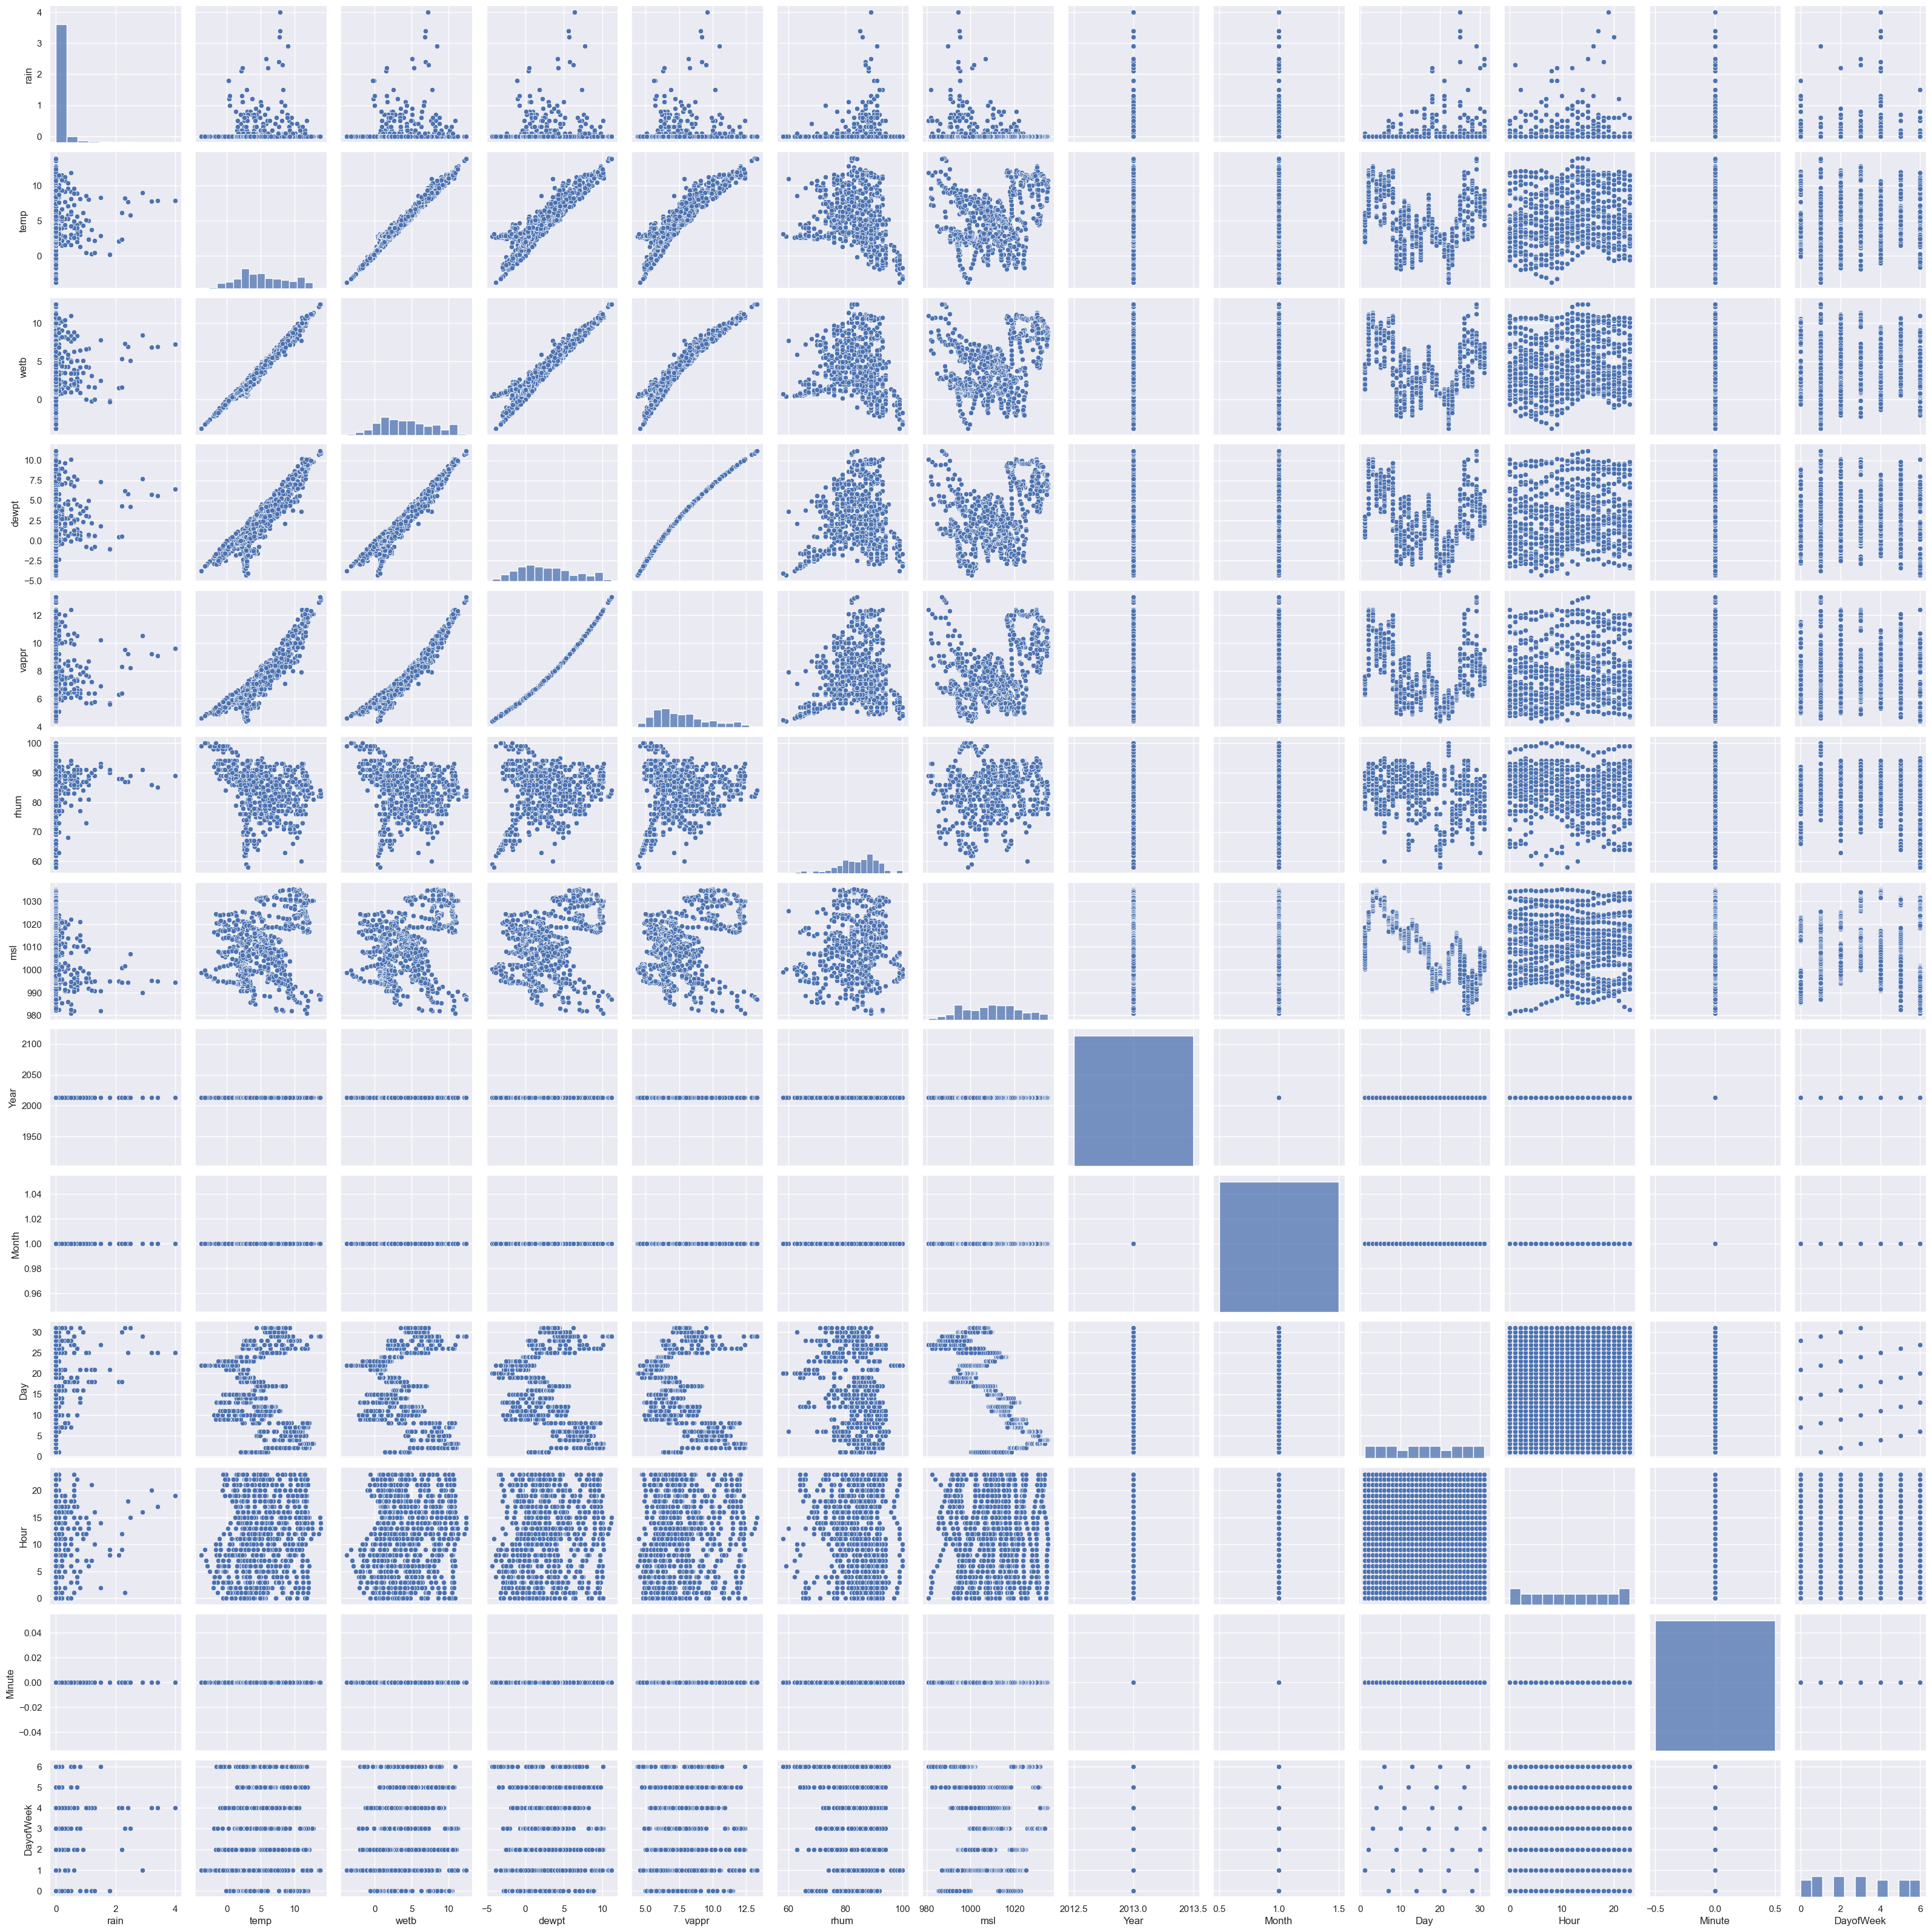

In [45]:
sns.pairplot(Phoenix_wdf)

In [46]:
c_wd = Phoenix_wdf.corr('pearson', numeric_only=True)

<AxesSubplot: >

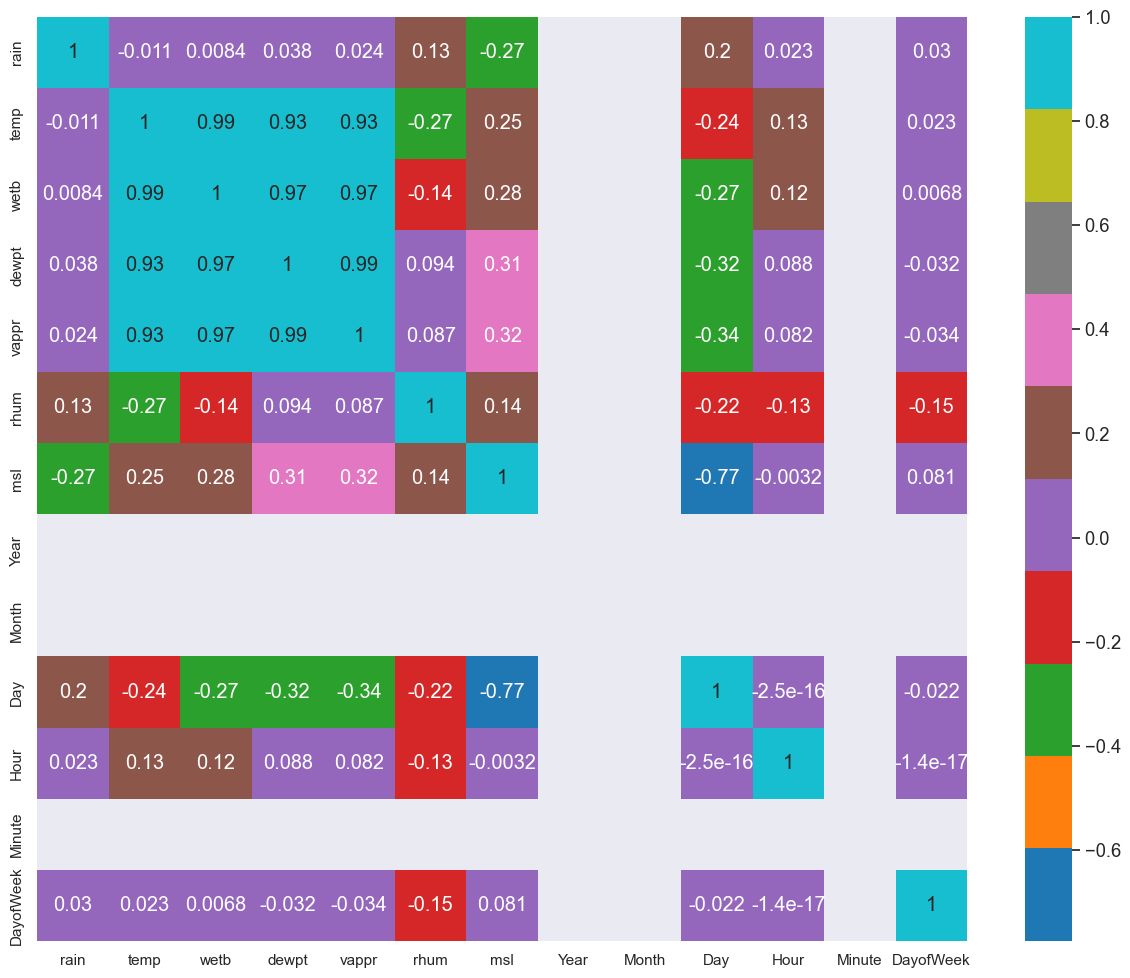

In [47]:
fig, ax = plt.subplots(figsize=(15,12))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_wd, cmap="tab10", annot=True)

In [48]:
#join weather and bus 
mdf = pd.merge(Phoenix_wdf, df)
mdf.head()

date  rain  temp  wetb  dewpt  vappr  rhum     msl  \
0  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
1  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
2  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
3  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   
4  01-jan-2013 11:00   0.0   3.6   2.7    1.2    6.7  84.0  1009.0   

             datetime  Year  ...  Congestion  LonWGS84   LatWGS84  Delay  \
0 2013-01-01 11:00:00  2013  ...           0 -6.116812  53.499493    -20   
1 2013-01-01 11:00:00  2013  ...           0 -6.212467  53.324749      0   
2 2013-01-01 11:00:00  2013  ...           0 -6.451066  53.347698      0   
3 2013-01-01 11:00:00  2013  ...           0 -6.394768  53.393051   -333   
4 2013-01-01 11:00:00  2013  ...           0 -6.373067  53.286098      0   

   BlockID  VehicleID  StopID  AtStop  Ontime  Colour  
0   332001      33625  3732.0       0       1  Yellow  
1     1001      33384   381.0       1       1  Yellow  
2    25003      33403  4620.0       1       1  Yellow  
3    39002      33585  4489.0       0       0   Black  
4    76002      33409  4341.0       1       1  Yellow  

[5 rows x 33 columns]

<AxesSubplot: >

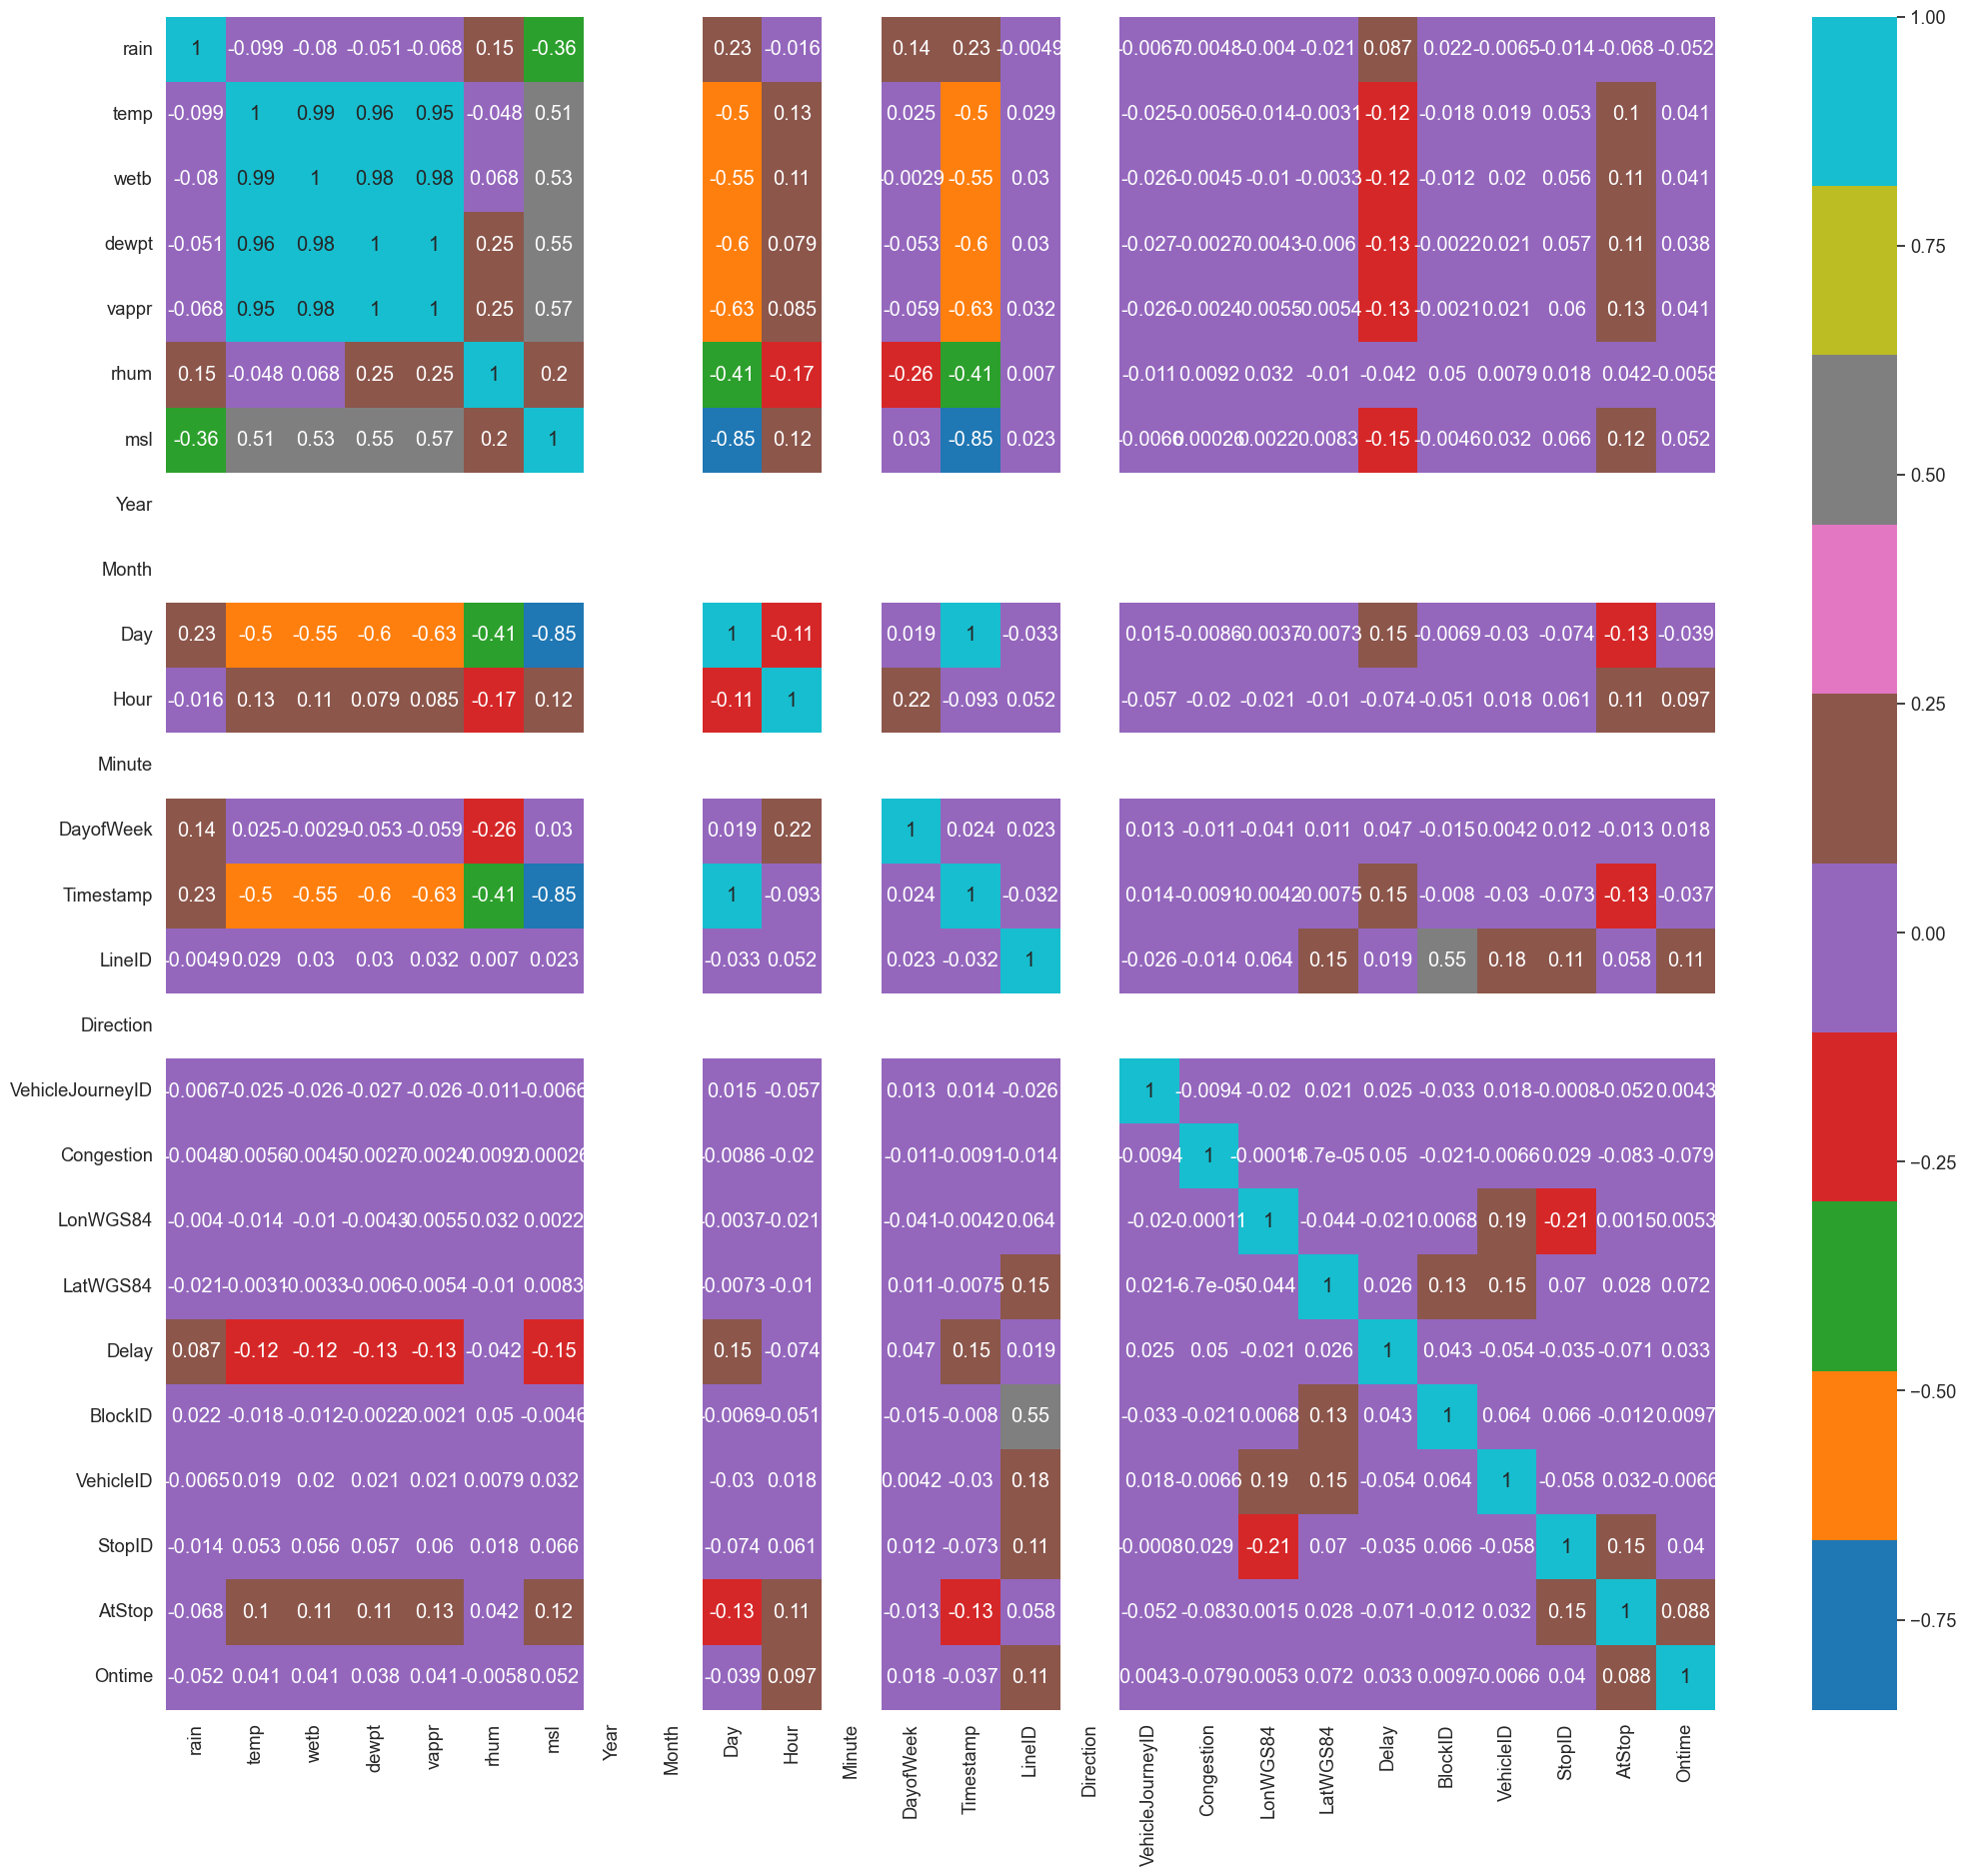

In [49]:
c_df = mdf.corr('pearson', numeric_only=True)
fig, ax = plt.subplots(figsize=(25,22))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
sns.heatmap(c_df, cmap="tab10", annot=True)

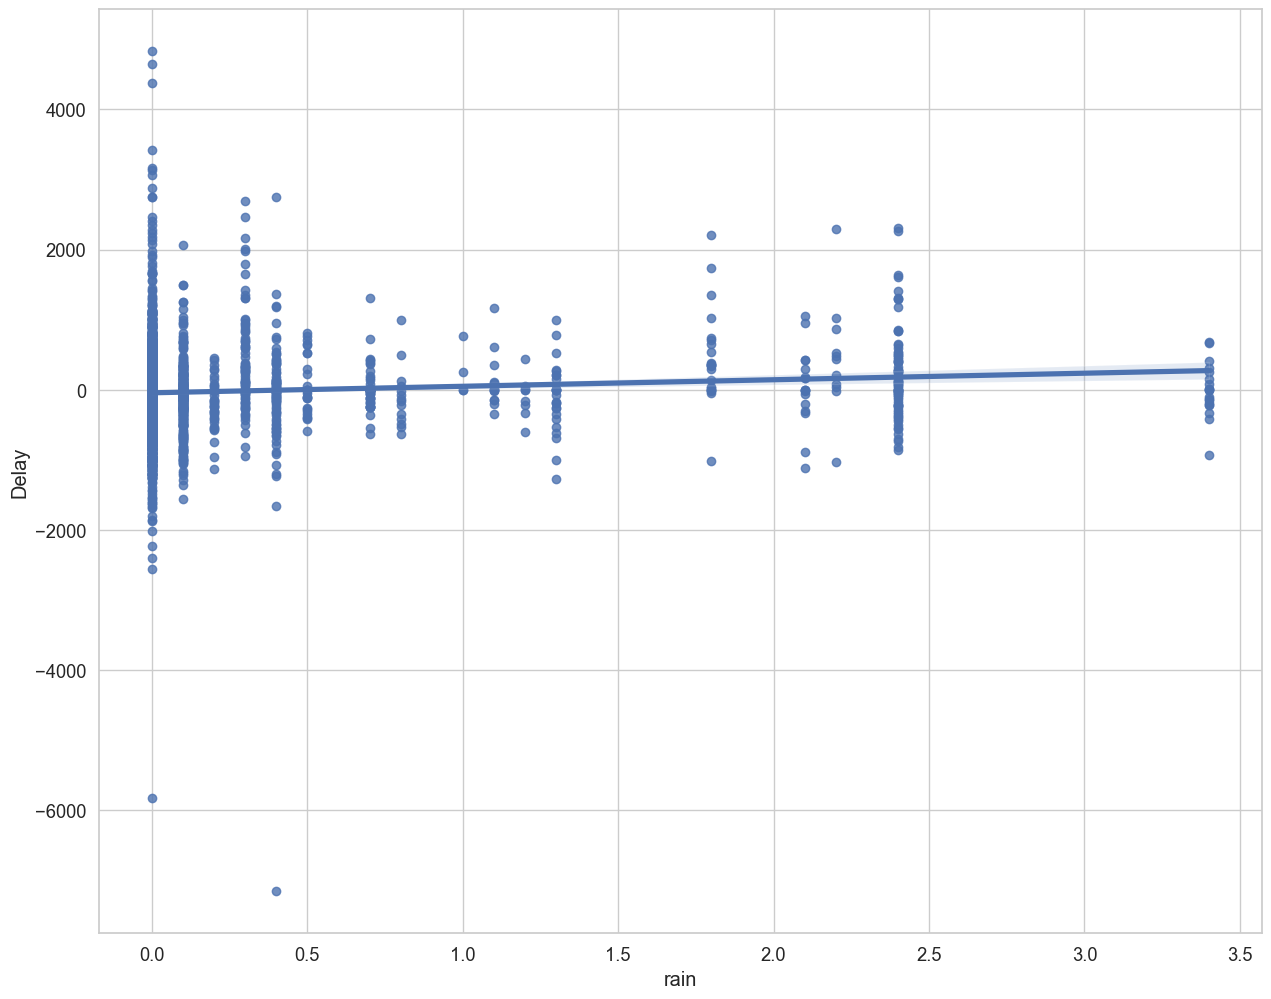

In [50]:

fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain' , y = 'Delay');


<AxesSubplot: xlabel='msl', ylabel='Delay'>

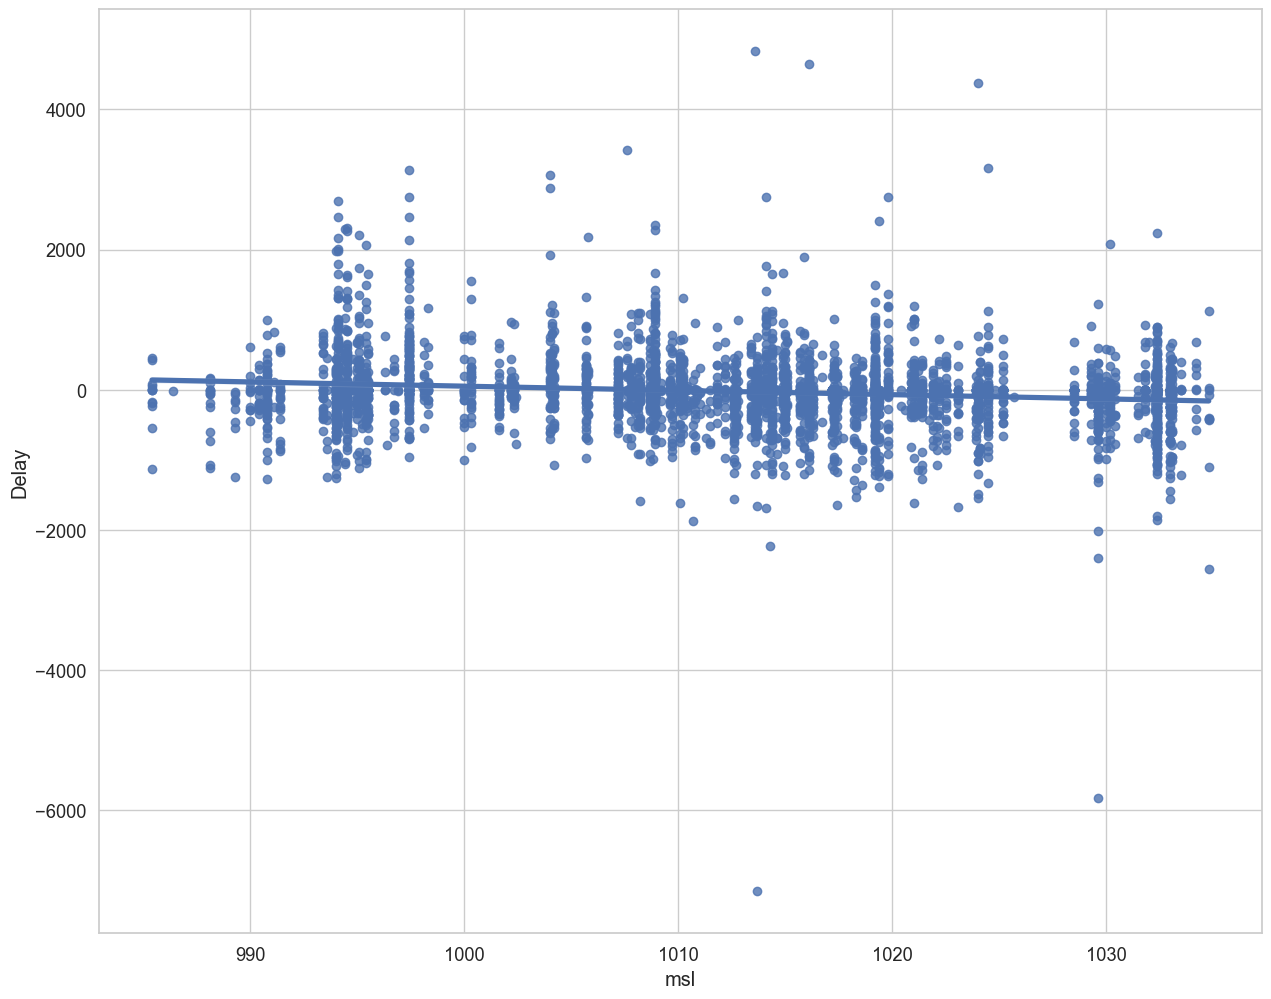

In [51]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'msl' , y = 'Delay')


<AxesSubplot: xlabel='Day', ylabel='Delay'>

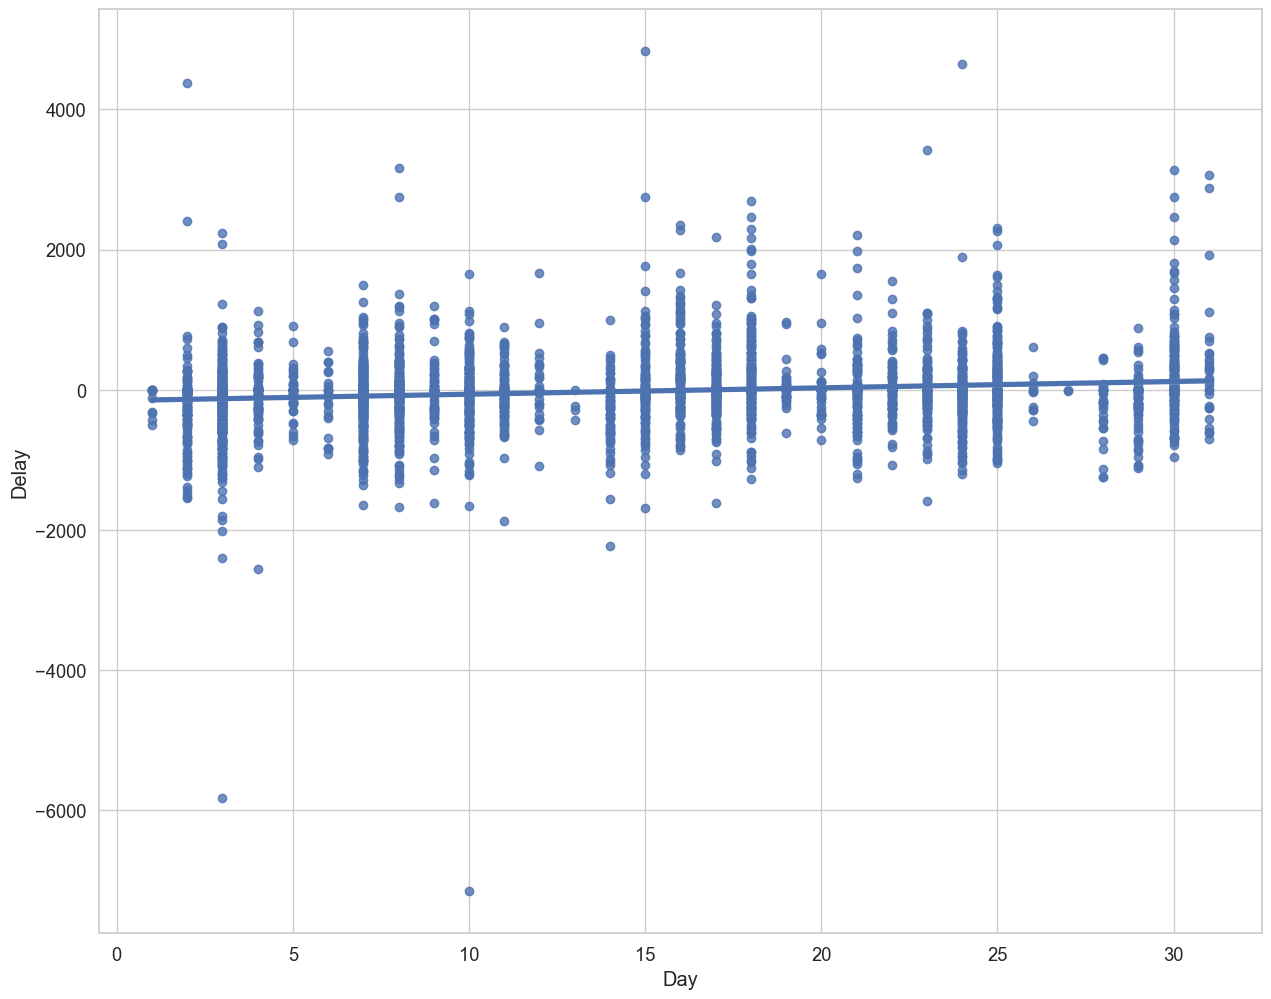

In [52]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'Day' , y = 'Delay')

<AxesSubplot: xlabel='DayofWeek', ylabel='Delay'>

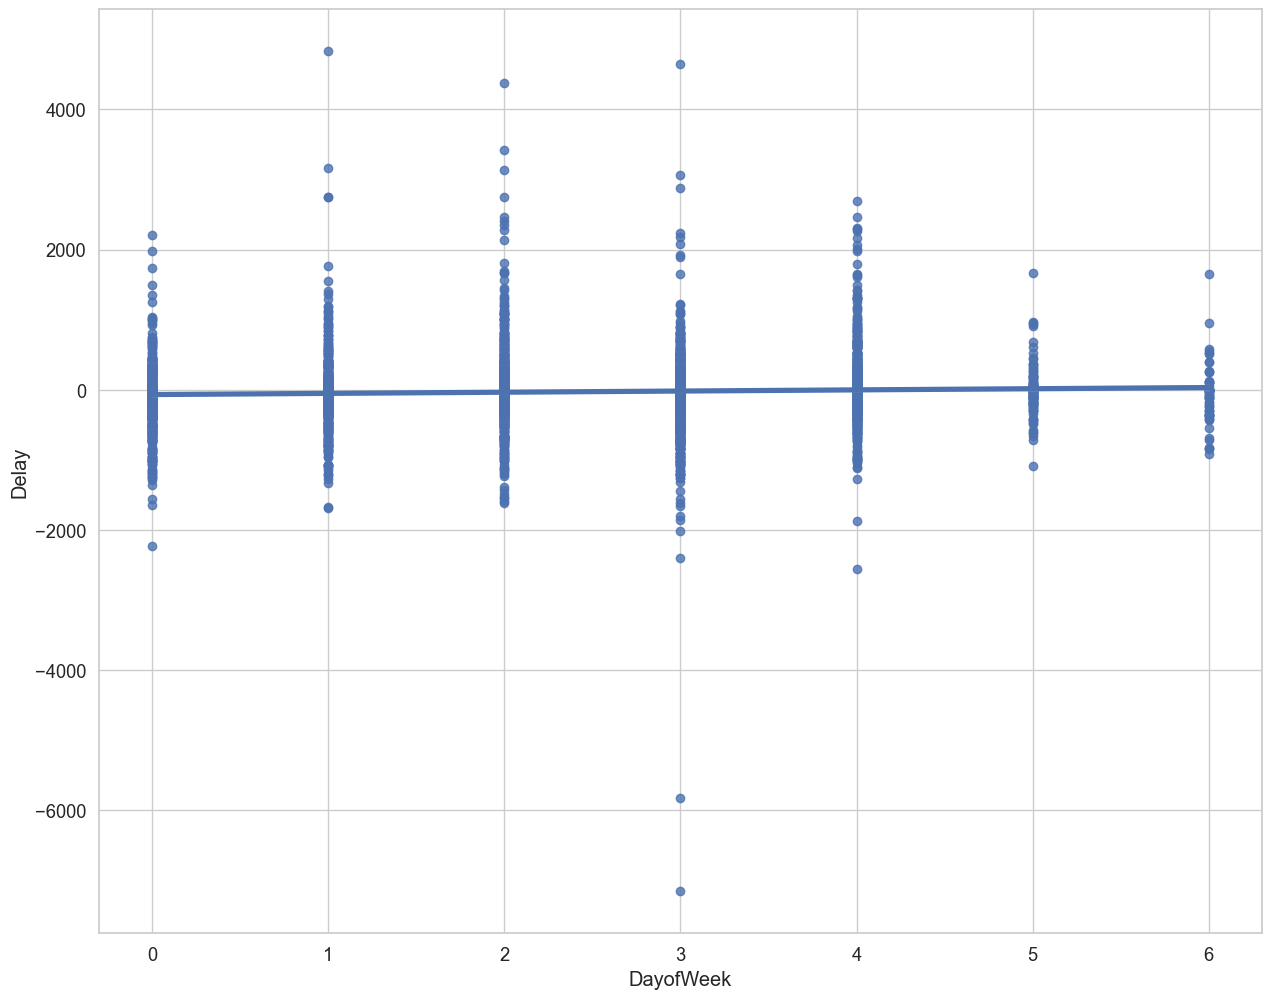

In [53]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'DayofWeek' , y = 'Delay')

<AxesSubplot: xlabel='rain', ylabel='Ontime'>

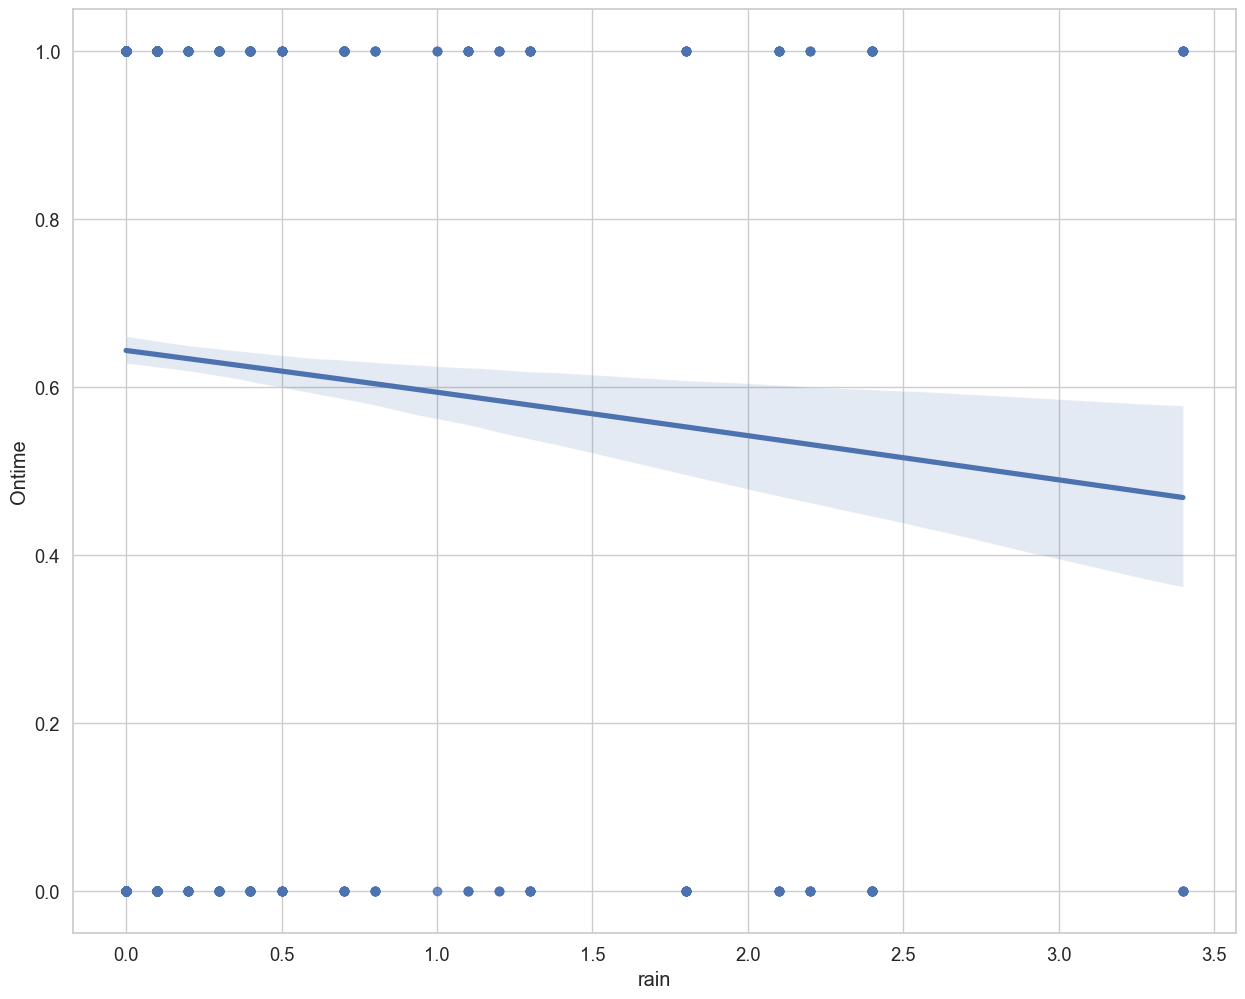

In [54]:
fig, ax = plt.subplots(figsize=(15,12))
sns.regplot(mdf, x = 'rain', y = 'Ontime', logistic = True)

### display histogram of the new data set

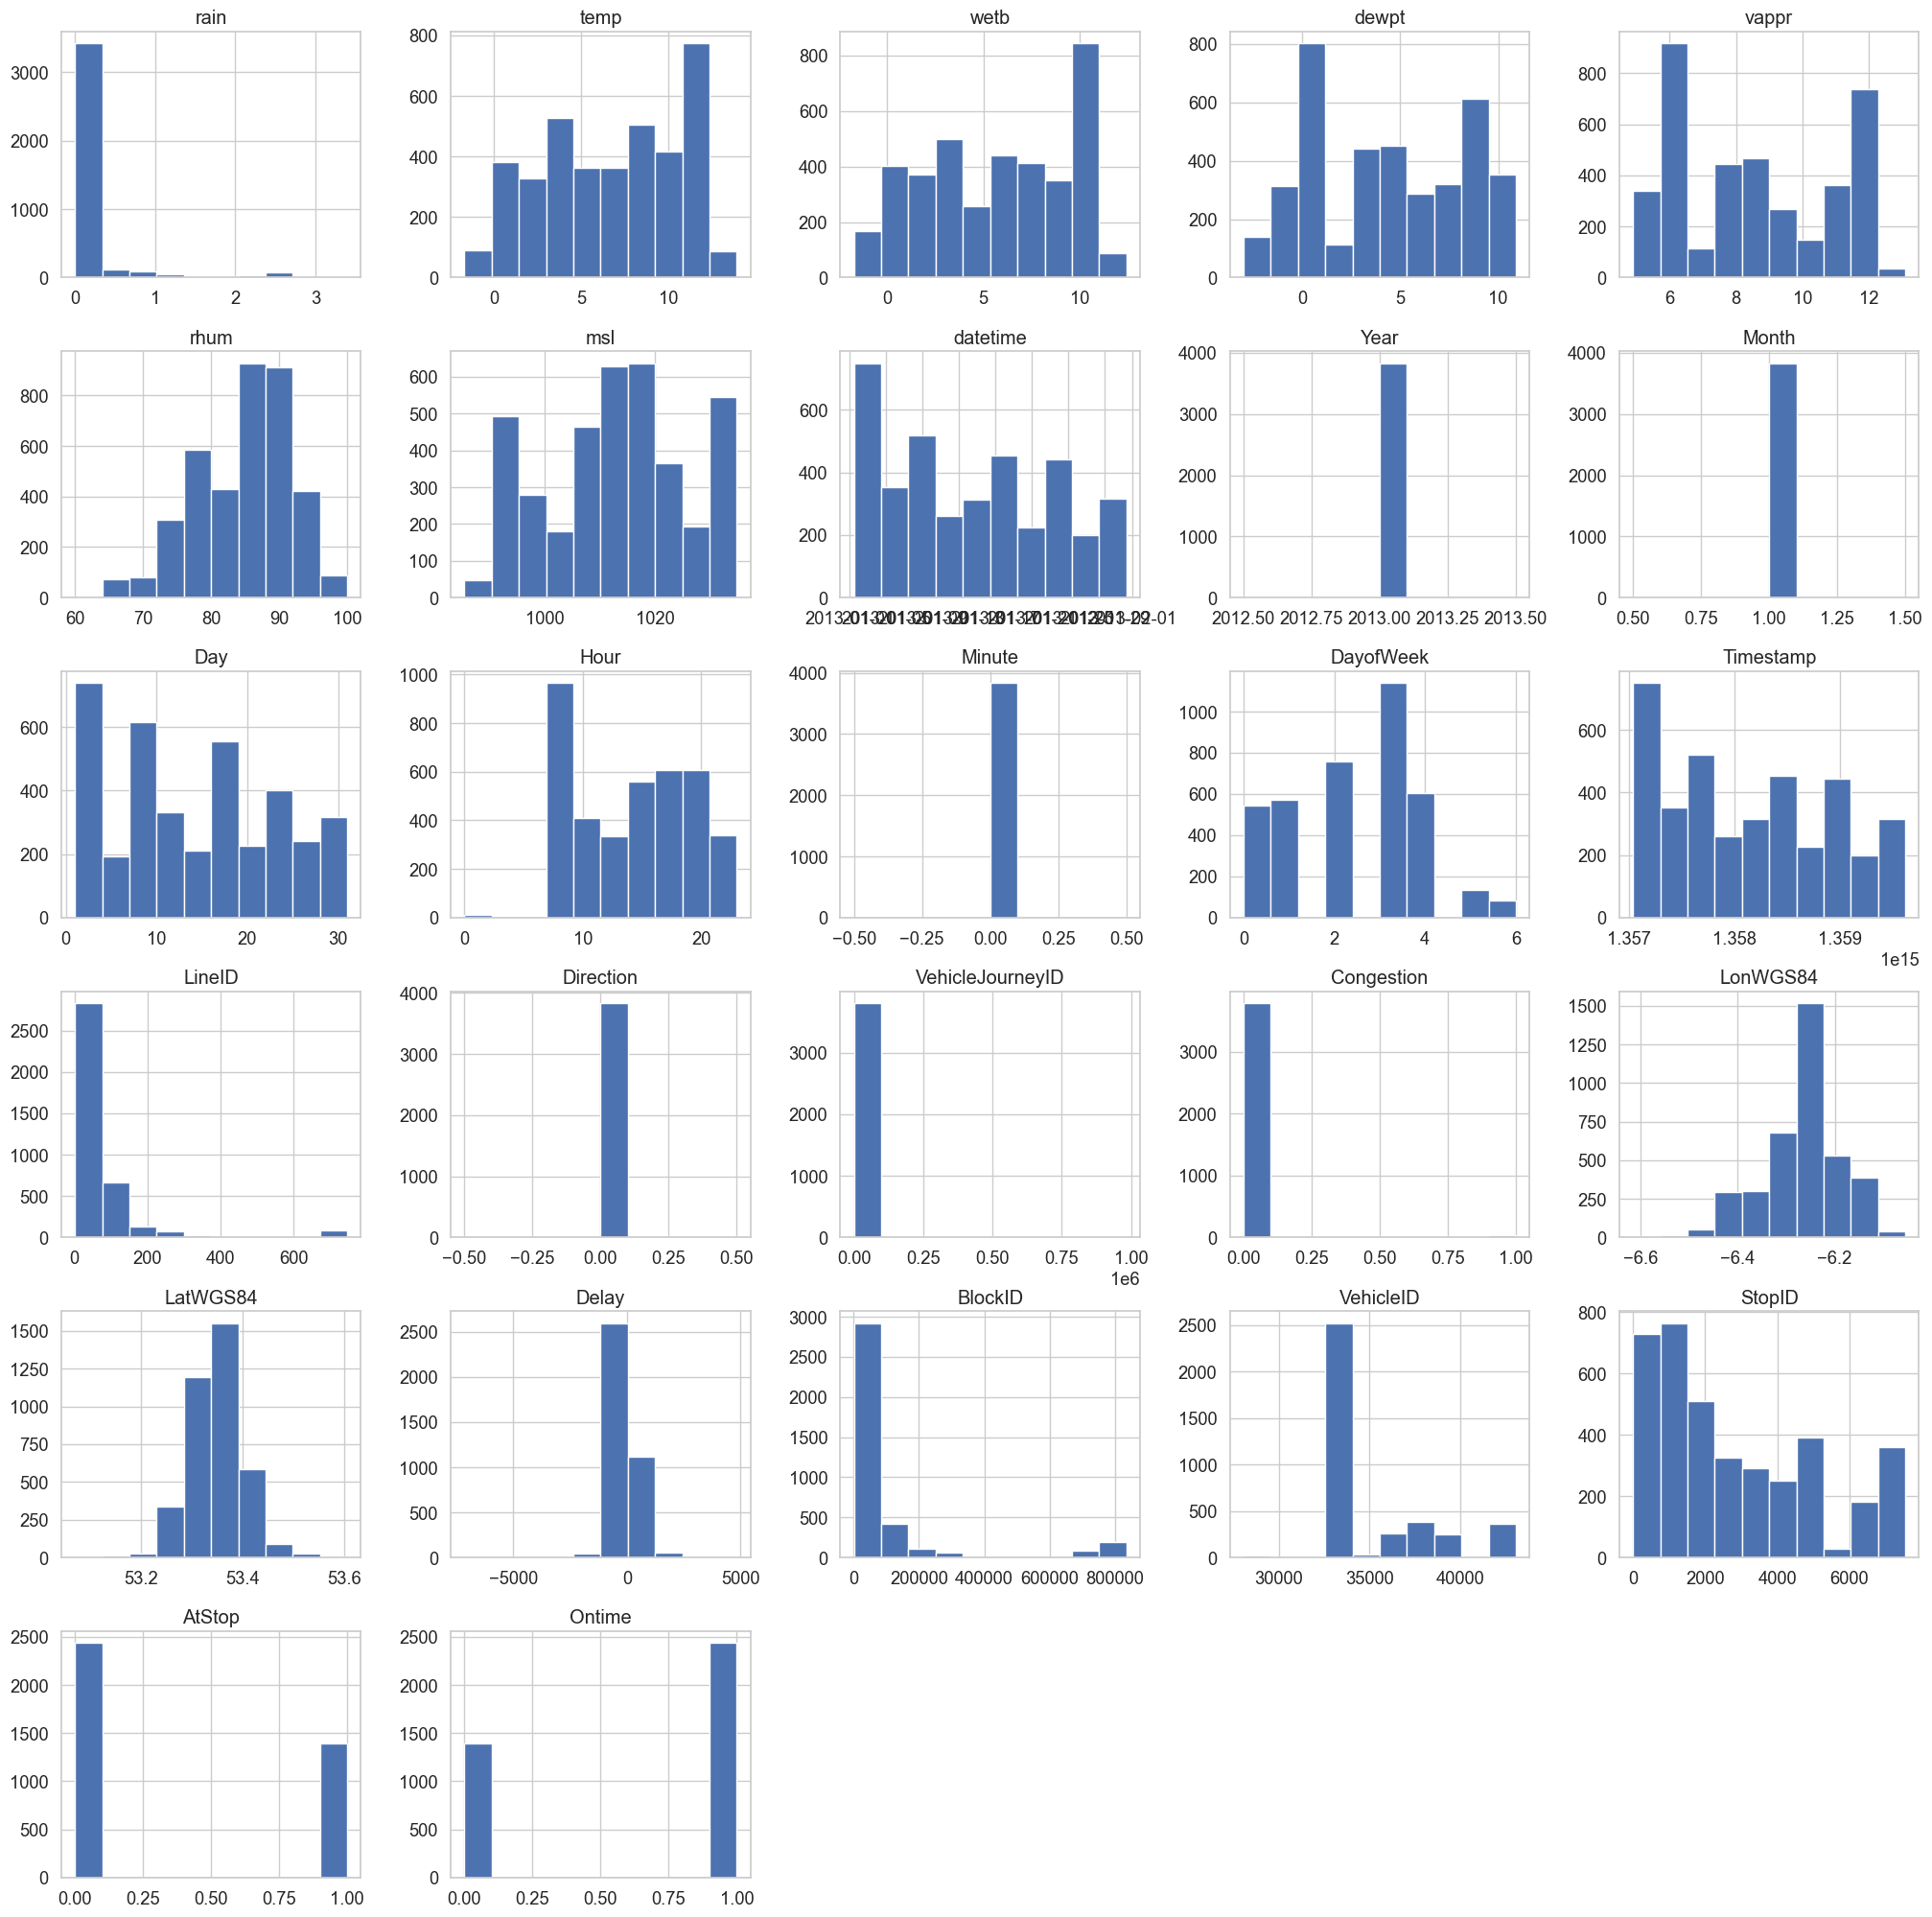

In [55]:
mdf.hist(figsize=(25,25));

In [56]:
busRoutes = mdf['LineID'].unique()
display(busRoutes)
busRoutes = sorted(busRoutes)
w1_value = ''
w1 = None
w1 = widgets.Dropdown(
    options= busRoutes,
    value= busRoutes[0],
    description = 'Bus Route',
    )

i = interactive(custom_scatterplot, df1 =fixed(df), col1=w1)
hbox = widgets.HBox(i.children)
display(hbox)

array([332.,   1.,  25.,  39.,  76., 171.,  83., 238., 151.,  41.,  14.,
        33.,  15.,  11., 145.,  32., 123.,  49.,  66.,   9., 150.,  16.,
         4., 102., 122.,  27.,  46., 120., 271.,  38.,  68.,  54.,  31.,
       451.,  13.,  37., 114.,   7.,  40.,  84.,  29.,  17., 747.,  75.,
        65.,  56., 130.,  42., 272., 140., 220.,  18.,  51.,  63.,  44.,
        79., 331.,  59.,  67., 104., 111., 142., 116., 118.])

In [57]:
mdf.to_parquet('./Data/WeatherandBusData.parquet')

In [58]:
if len(mdf) > 5000: # limiting the amount of data that is being sent to the function because of memory issues 
    sampleSize = 5000
else:
    sampleSize = len(mdf)
for f in NumericalColumns:
    print(f)
    custom_barplot( df1=mdf.sample(sampleSize), col1=f)

Delay
BlockID
AtStop
StopID
Day
LatWGS84
DayofWeek
LineID
VehicleID
VehicleJourneyID
Timestamp
Hour
LonWGS84
Minute


LinAlgError: singular matrix

Error in callback <function _draw_all_if_interactive at 0x000001669D88A790> (for post_execute):
